In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.ipc_collect()
#device = "cpu"

In [2]:
 def plot_stuff(model,X,y,x_biased,mbins=100,histbins=None,name='Naive DNN'):
    if histbins == None:
        histbins=mbins
    predictions = np.array(model(X).tolist()).flatten()
    metrics_test = Metrics(validation=True)
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    x_biased = (x_biased+1)*0.5 *250 
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    sorted_m = np.argsort(m)
    scores = predictions[y==1][sorted_m].reshape(mbins,-1)
    m = m[sorted_m]
    m = m.reshape(mbins,-1).mean(axis=1)
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    plt.show()
    return (1/JSD,R50)

In [3]:
# mbins = 10
# mcontent = 4
# li = LegendreIntegral.apply
# fitter = LegendreFitter(mbins=mbins,power=2)
# inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
# inputTensor.requires_grad_(True)
# sbins = 1000
# integral = li(inputTensor,fitter,sbins
#              )
# integral
# gradcheck(li,(inputTensor,fitter,sbins
#              ),eps=0.01,atol=0.01)

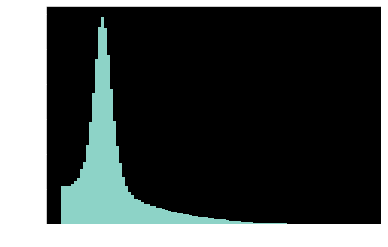

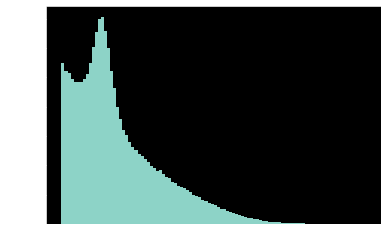

device: cuda:0


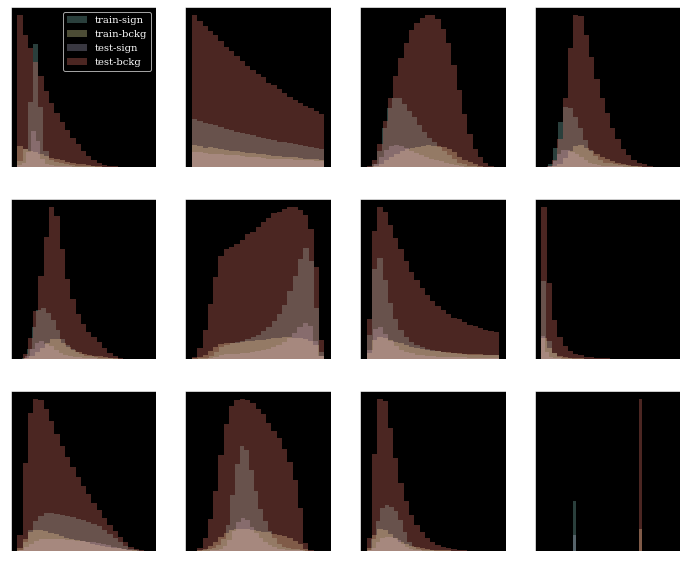

In [4]:
#dataset 
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
train[::,0] = 2*train[::,0]-1
#train[::,0][train_labels==1] = 2*(np.argsort(train[::,0][train_labels==1]))/(train_labels==1).sum()-1

plt.hist(train[::,0],bins=100)
plt.show()

maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)
val[::,0] = 2*val[::,0]-1
plt.hist(val[::,0],bins=100)
plt.show()

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
test = files["test"]
test_labels=test[::,-1]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)
test[::,0] = 2*test[::,0]-1
X = torch.from_numpy(test[:,1:11]).float().to(device)

print('device:', device)



# maxdata = val.max(axis=0)
# mindata = val.min(axis=0)
# val = (val-mindata)/(maxdata-mindata)

# m,dm = np.histogram(train[::,0],bins=train.shape[0],density=True)
# train[::,0] = np.cumsum(m*(dm[1]-dm[0]))
# m,dm = np.histogram(val[::,0],bins=val.shape[0],density=True)
# val[::,0] = np.cumsum(m*(dm[1]-dm[0]))
# m = train[::,0].argsort()
# m = m/m.size
#train[::,0] = 2*train[::,0]-1
# m = val[::,0].argsort()
# m = m/m.size
# val[::,0] = 2*m-1
fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
    

In [5]:
params = {'epochs'     : 200,
          'interval'   : 200,
          'batch_size' : 2048*2**4,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

# Flat bins 

Entering Training...
Epoch:0001/0200  (8.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (380.8s)
 Train: loss:0.2152, acc:80% || Val: loss: 0.0630, acc:86%, R50: 25.5082, 1/JSD: 1.1946


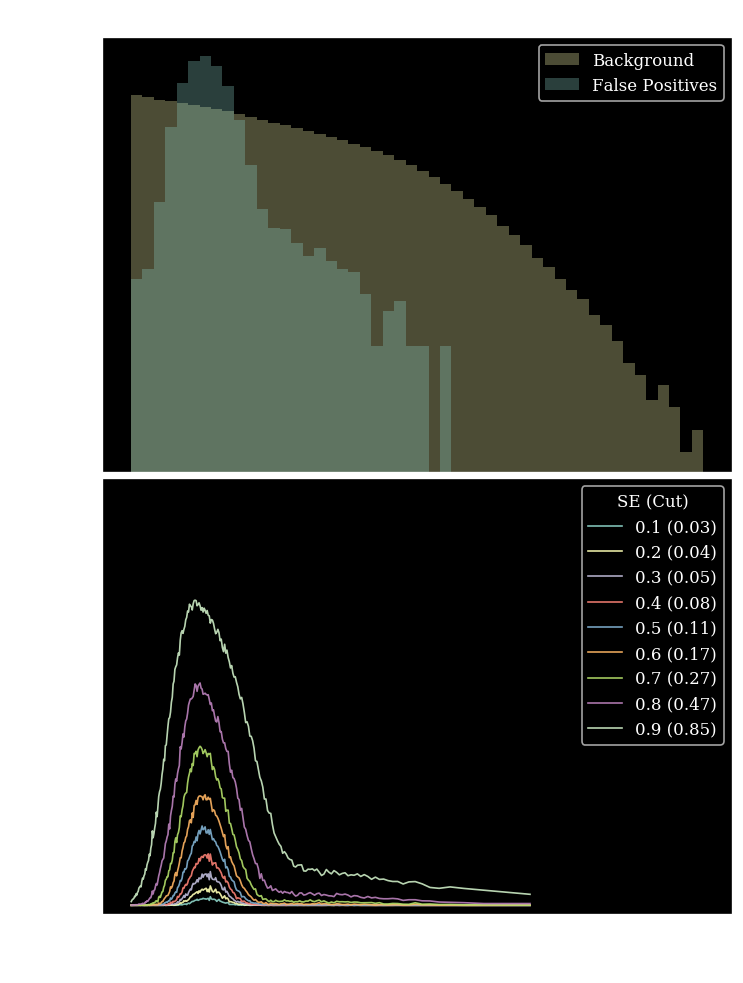

Entering Training...
Epoch:0001/0200  (8.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (384.8s)
 Train: loss:0.2279, acc:79% || Val: loss: 0.0631, acc:85%, R50: 21.9766, 1/JSD: 1.8362


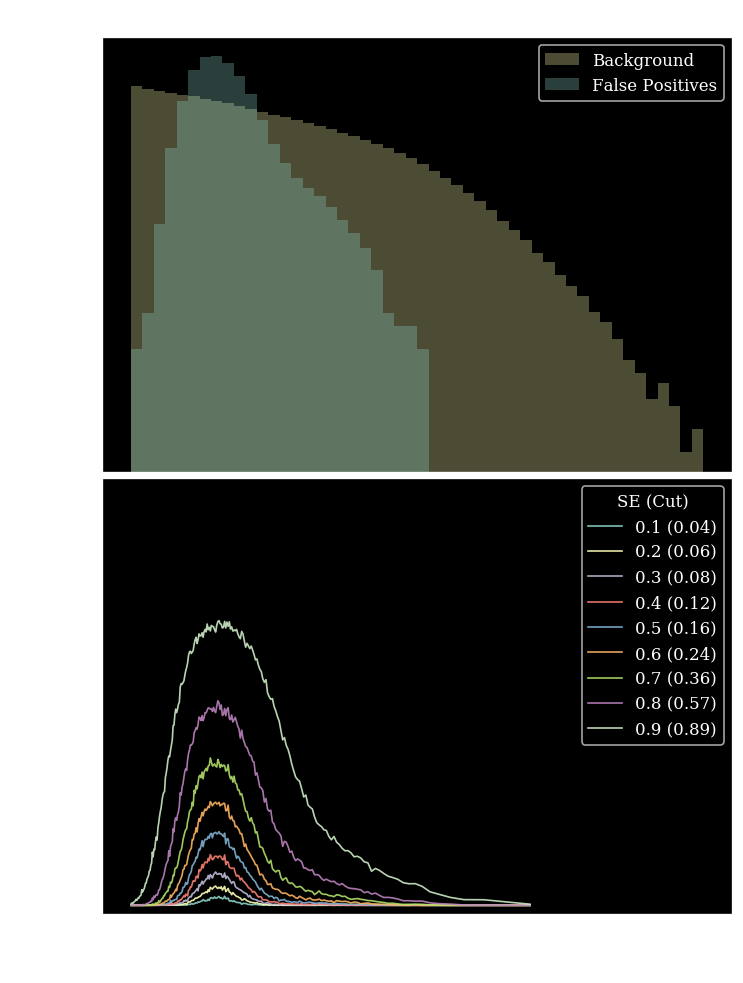

Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (403.8s)
 Train: loss:0.2750, acc:74% || Val: loss: 0.0764, acc:81%, R50: 10.9872, 1/JSD: 23.9251


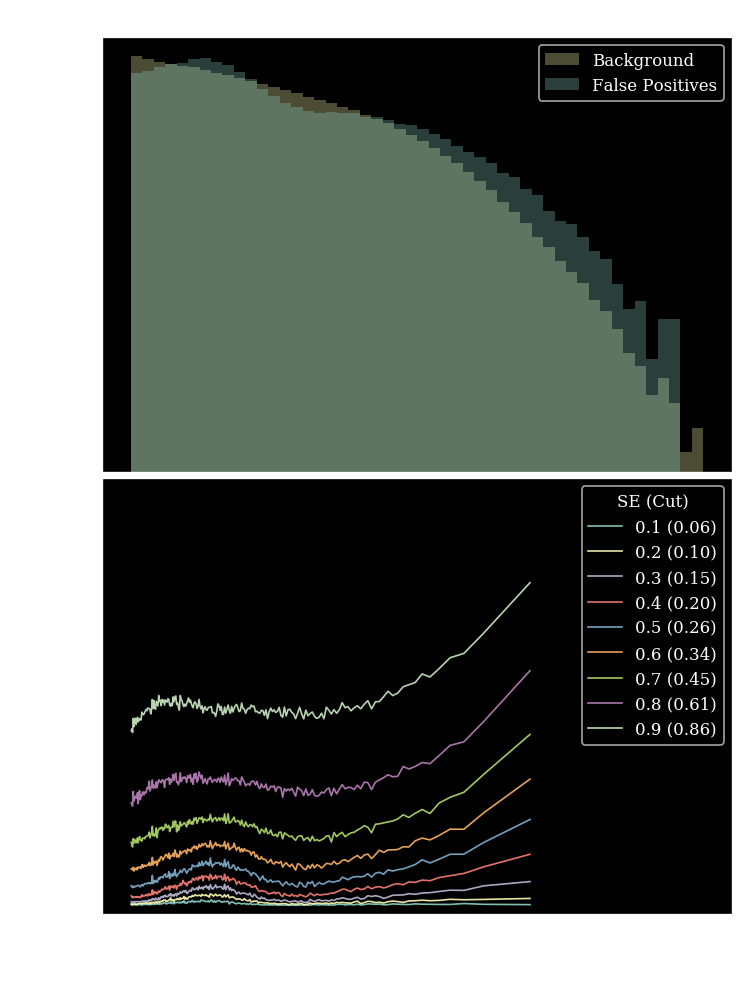

Entering Training...
Epoch:0001/0200  (8.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (376.8s)
 Train: loss:0.2680, acc:73% || Val: loss: 0.0752, acc:81%, R50: 10.8660, 1/JSD: 67.5572


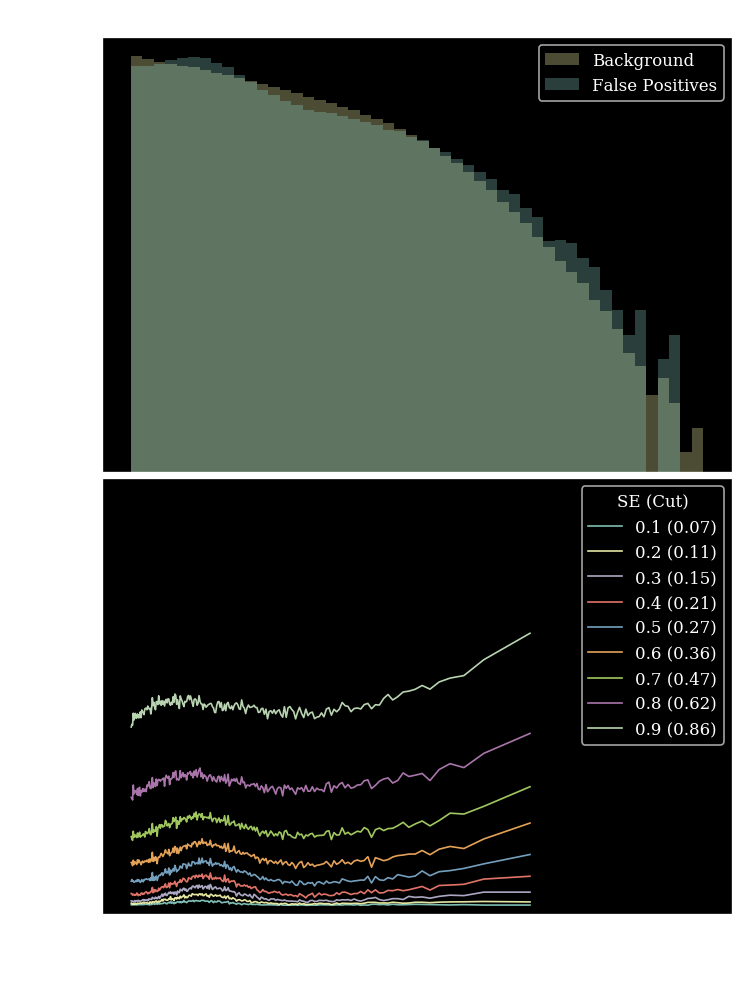

Entering Training...
Epoch:0001/0200  (8.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (386.5s)
 Train: loss:0.3030, acc:72% || Val: loss: 0.0768, acc:82%, R50: 10.5881, 1/JSD: 80.8582


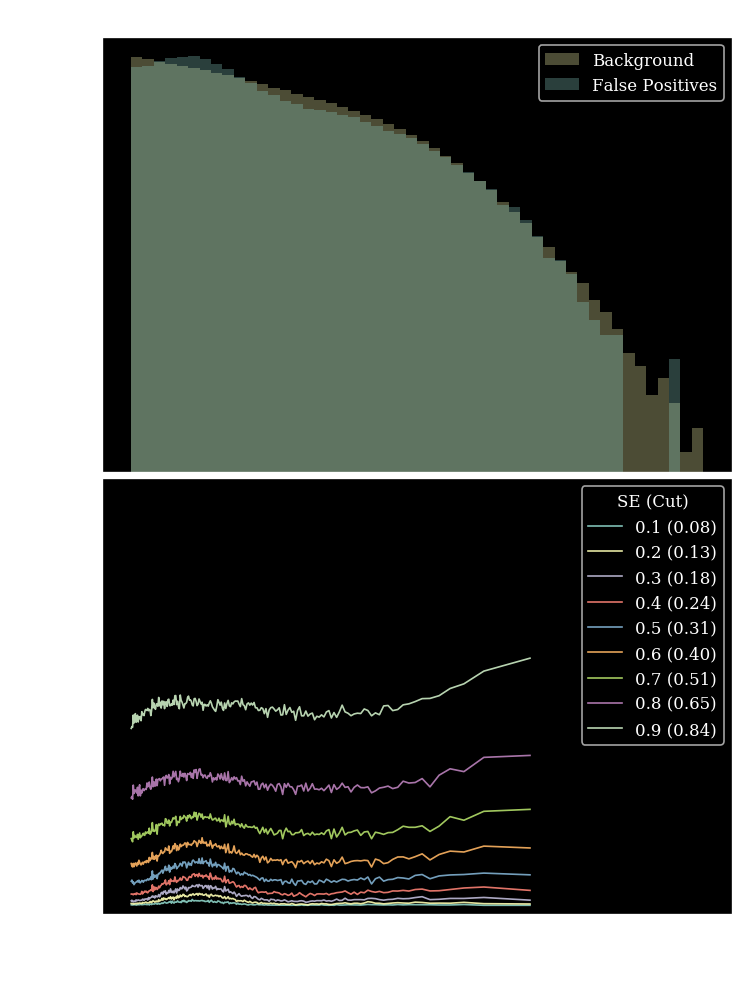

Entering Training...
Epoch:0001/0200  (8.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (392.7s)
 Train: loss:0.3102, acc:72% || Val: loss: 0.0774, acc:82%, R50: 10.6260, 1/JSD: 98.1218


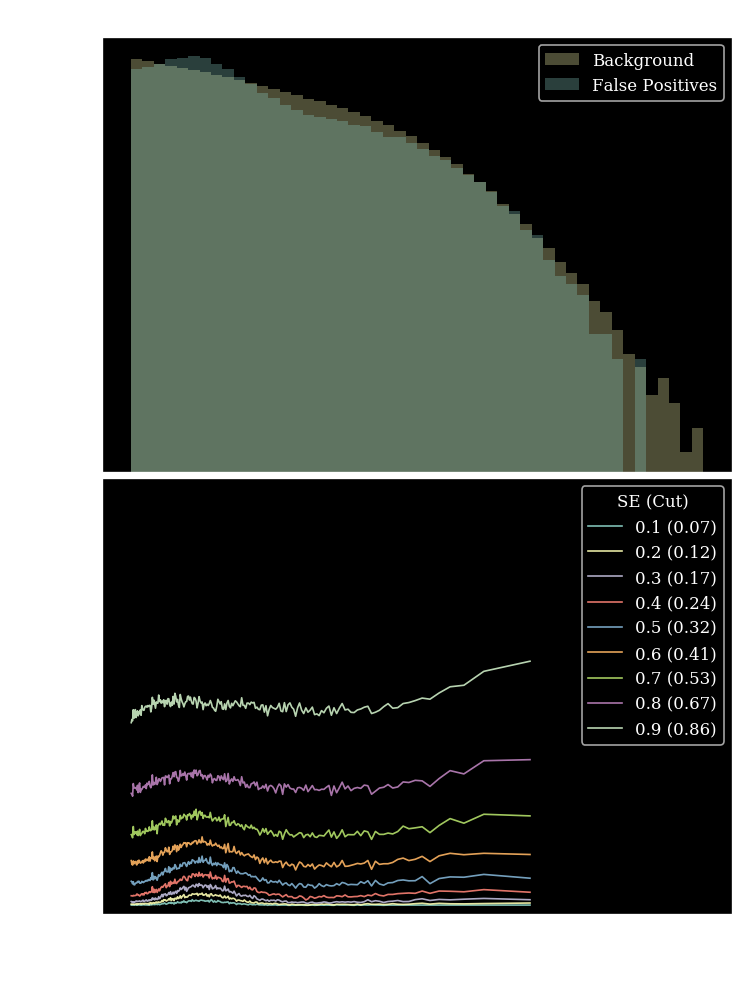

Entering Training...
Epoch:0001/0200  (8.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (368.4s)
 Train: loss:0.3074, acc:71% || Val: loss: 0.0770, acc:82%, R50: 10.9420, 1/JSD: 110.3477


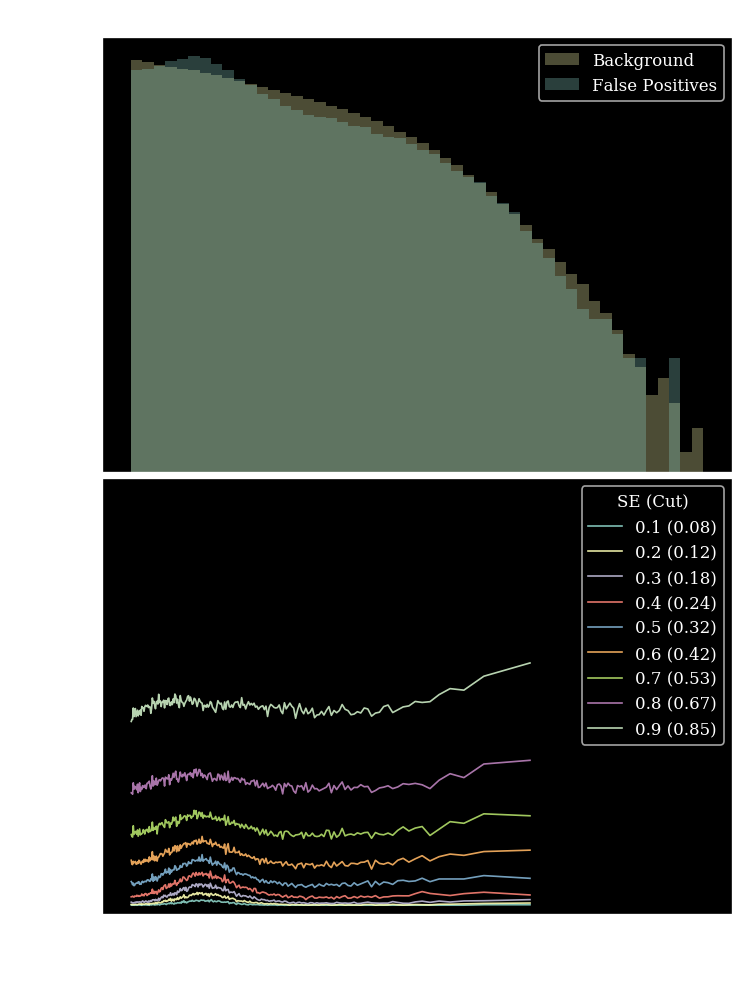

Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (368.7s)
 Train: loss:0.3226, acc:70% || Val: loss: 0.0773, acc:82%, R50: 10.9810, 1/JSD: 128.7703


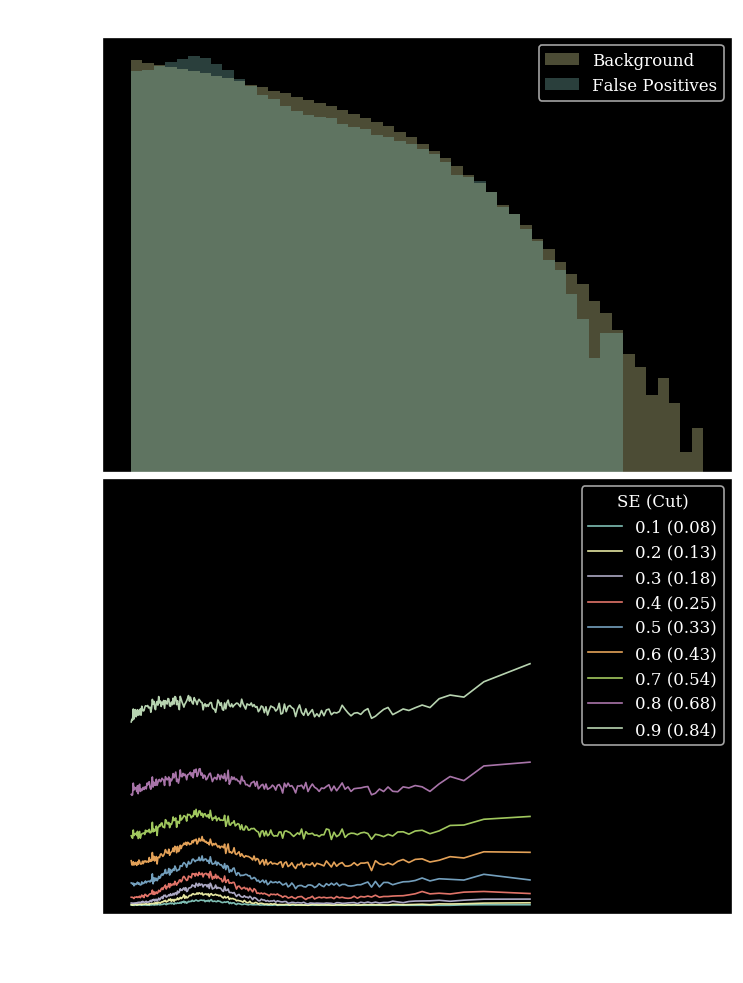

Entering Training...
Epoch:0001/0200  (8.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (375.4s)
 Train: loss:0.3328, acc:70% || Val: loss: 0.0793, acc:83%, R50: 10.6562, 1/JSD: 102.9669


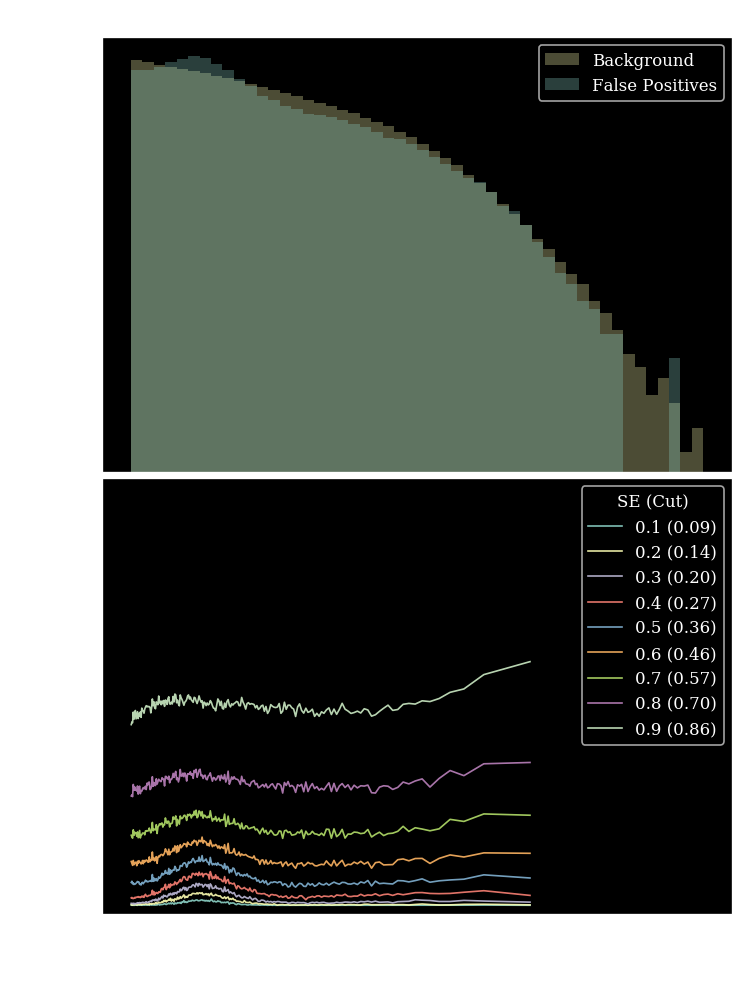

Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (367.0s)
 Train: loss:0.3393, acc:69% || Val: loss: 0.0804, acc:83%, R50: 10.5576, 1/JSD: 82.5040


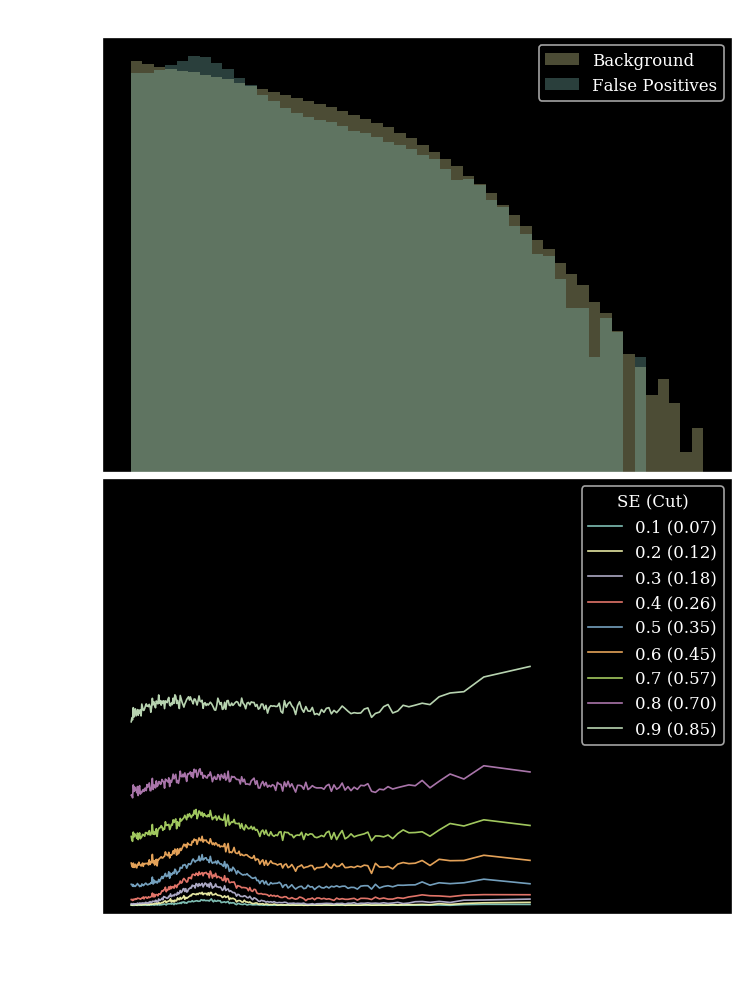

Entering Training...
Epoch:0001/0200  (8.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (373.3s)
 Train: loss:0.3411, acc:69% || Val: loss: 0.0798, acc:83%, R50: 11.0876, 1/JSD: 103.5672


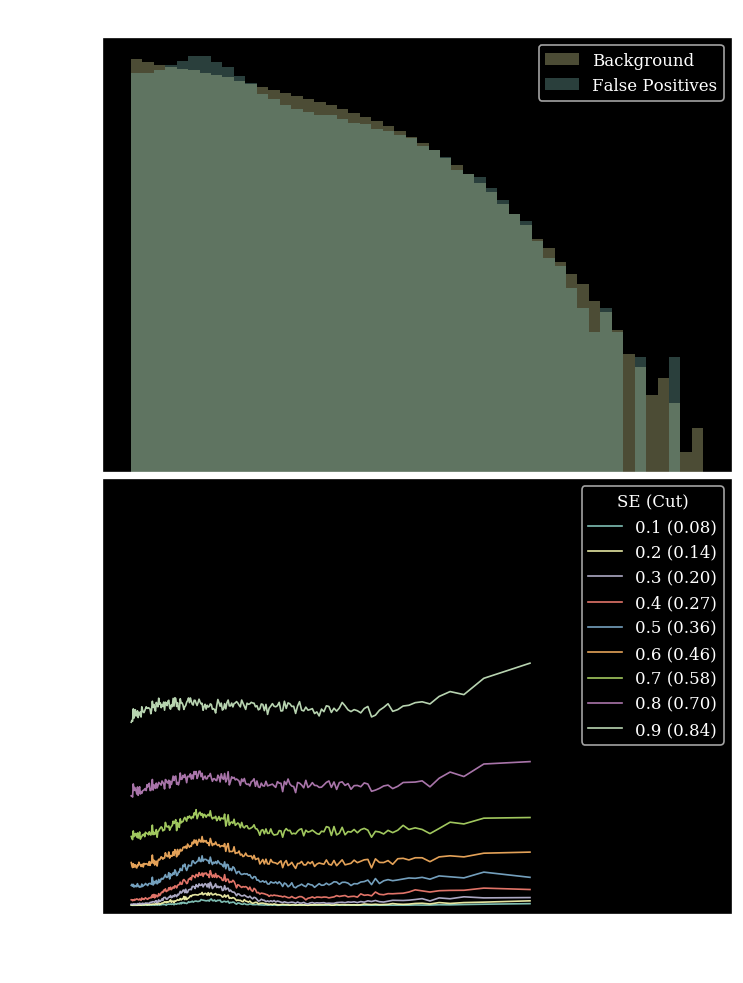

In [6]:
jsdR50flat = []
for i,bins in enumerate([1,2,5,10,50,60,75,85,100,110,120]):
    frac=50
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)
    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-3)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=1,bins=bins,memory=False)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN bins:{bins}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
    jsdR50flat.append(out)

In [ ]:
asfdsdf 

# Flat str

strength 1
Entering Training...
Epoch:0001/0200  (10.2 s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (410.1s)
 Train: loss:0.2072, acc:79% || Val: loss: 0.0584, acc:85%, R50: 23.6068, 1/JSD: 1.6663


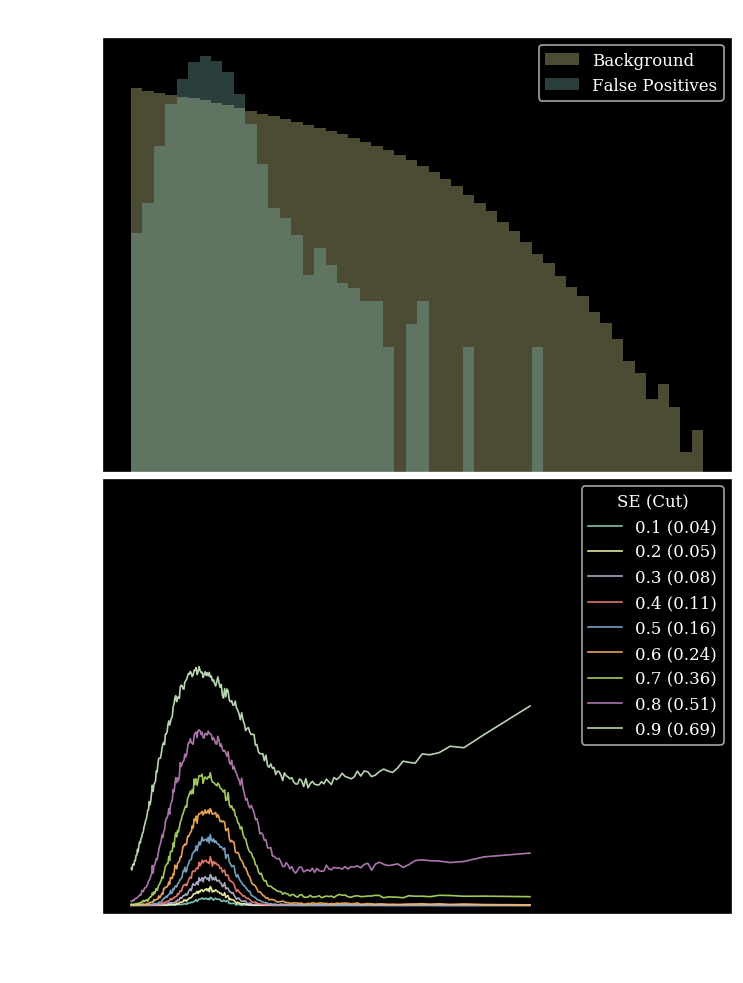

strength 1
Entering Training...
Epoch:0001/0200  (9.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (384.3s)
 Train: loss:0.2071, acc:79% || Val: loss: 0.0587, acc:85%, R50: 23.4375, 1/JSD: 1.7522


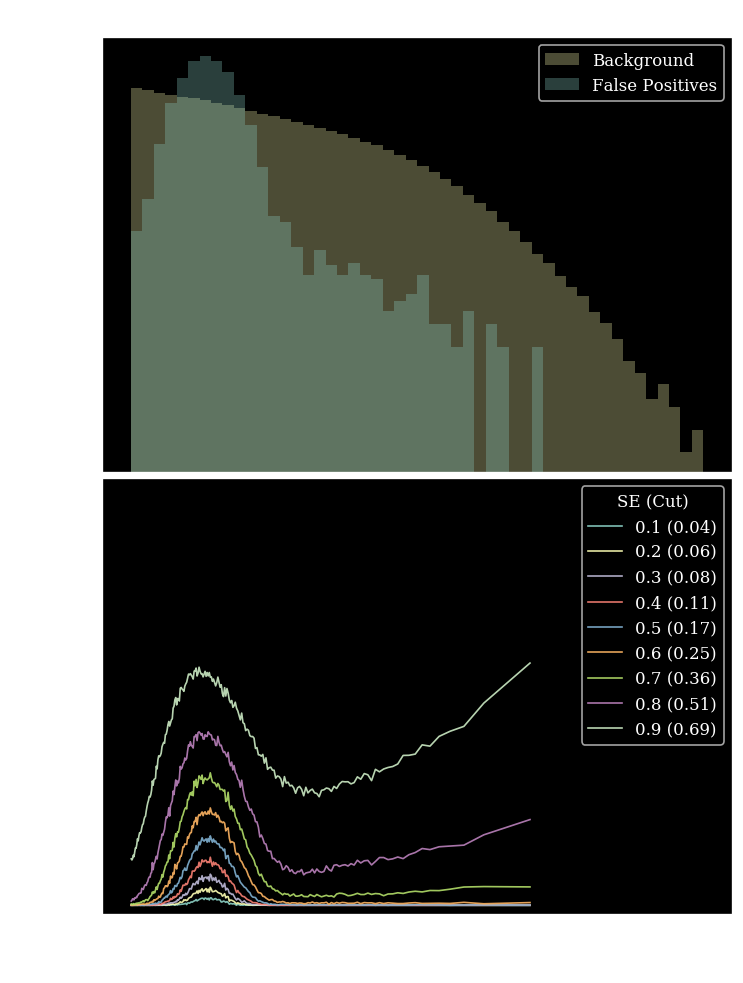

strength 1
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (386.3s)
 Train: loss:0.2072, acc:79% || Val: loss: 0.0586, acc:84%, R50: 23.2985, 1/JSD: 1.7397


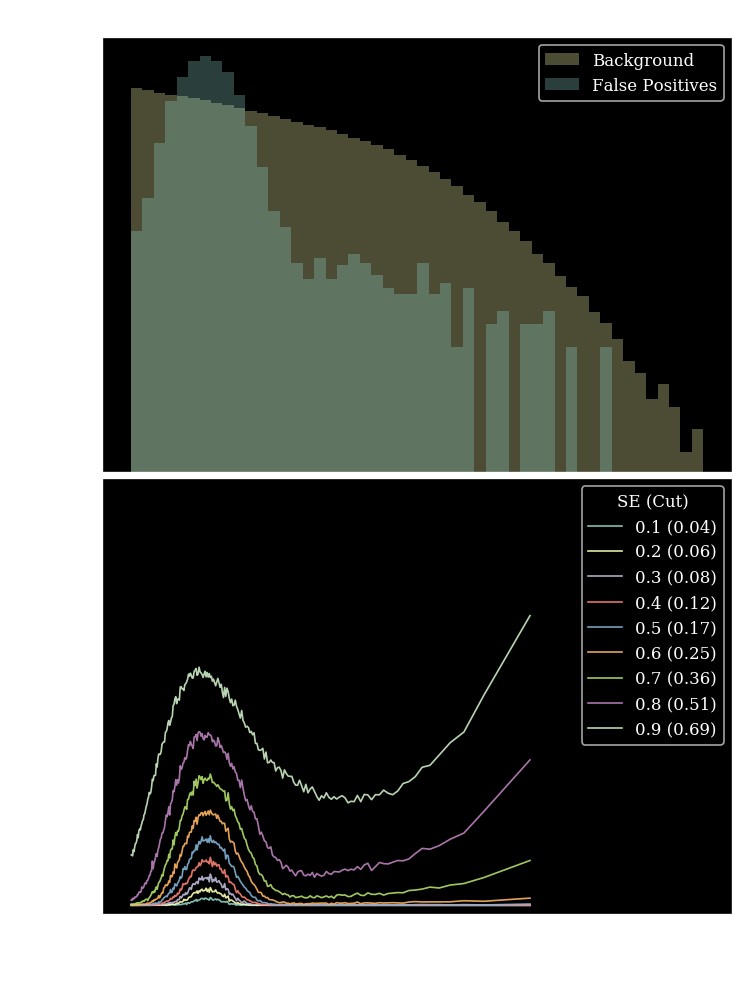

strength 50
Entering Training...
Epoch:0001/0200  (8.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (386.2s)
 Train: loss:0.3477, acc:70% || Val: loss: 0.0773, acc:78%, R50: 9.3484, 1/JSD: 151.0606


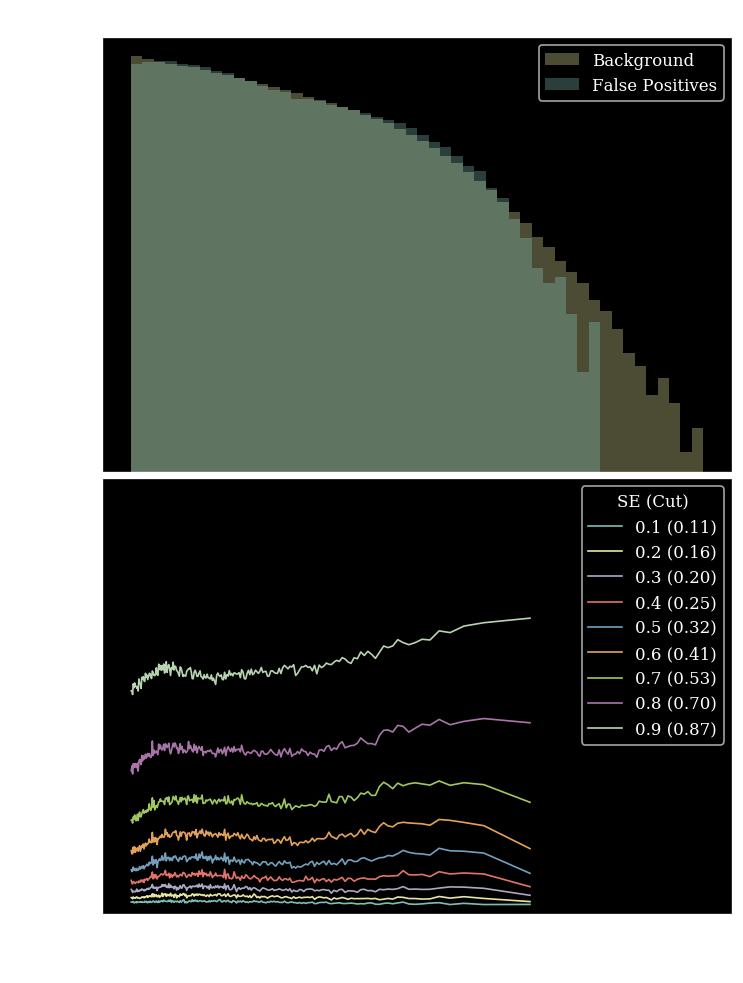

strength 50
Entering Training...
Epoch:0001/0200  (9.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (383.2s)
 Train: loss:0.3511, acc:69% || Val: loss: 0.0769, acc:78%, R50: 9.3769, 1/JSD: 138.0190


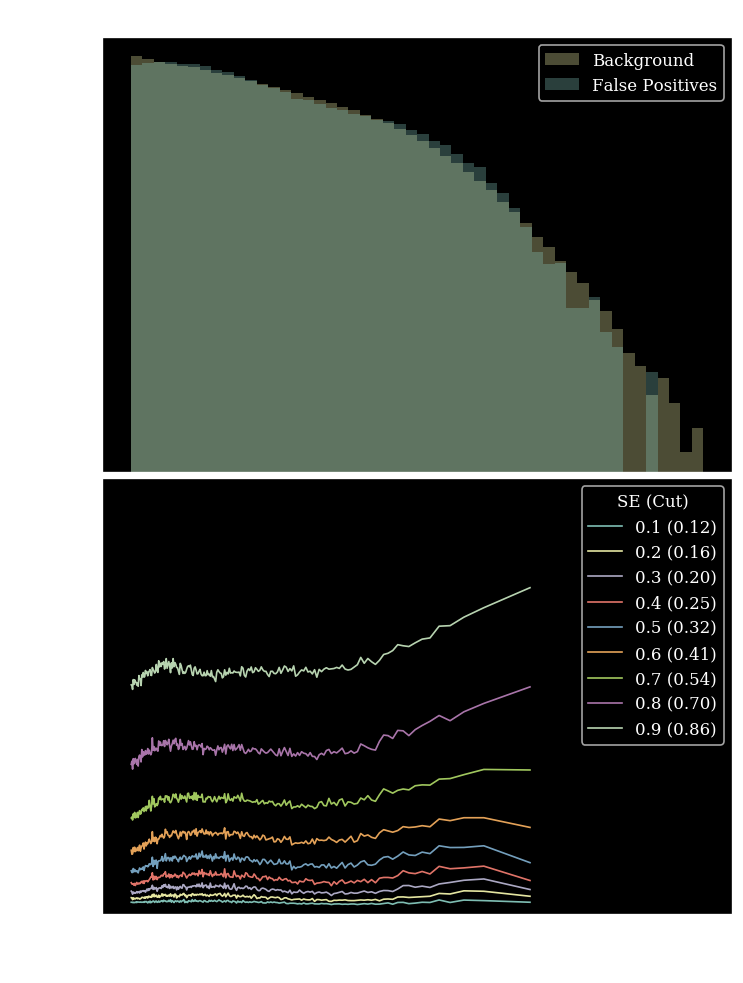

strength 50
Entering Training...
Epoch:0001/0200  (9.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (385.1s)
 Train: loss:0.3786, acc:69% || Val: loss: 0.0773, acc:78%, R50: 9.2414, 1/JSD: 211.9350


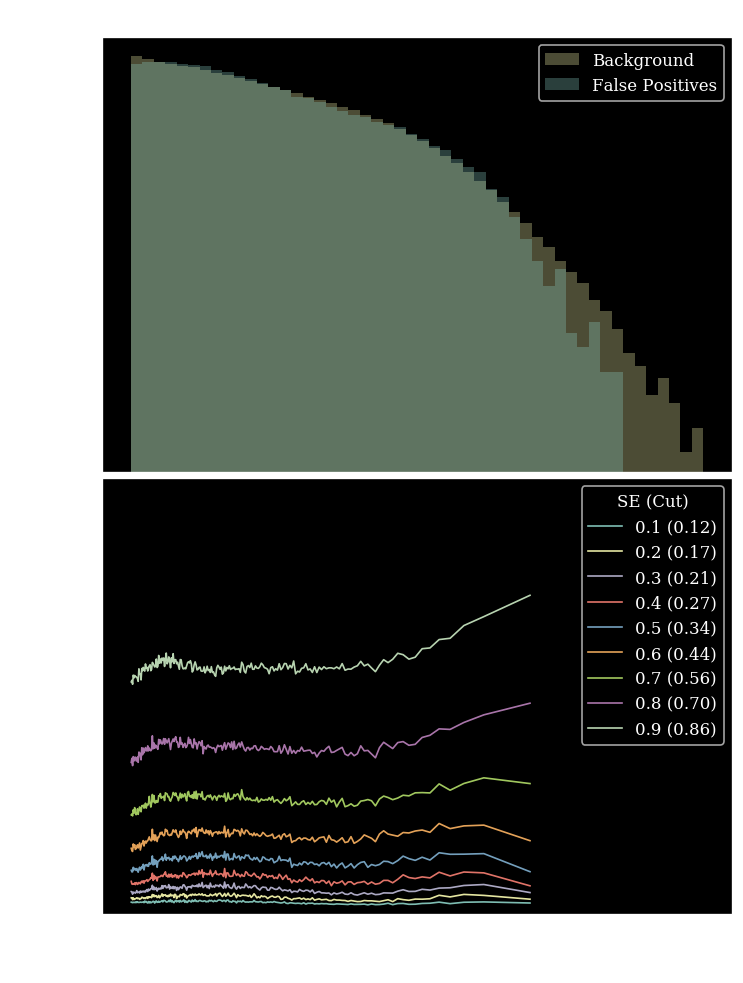

strength 60
Entering Training...
Epoch:0001/0200  (8.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (385.1s)
 Train: loss:0.3609, acc:69% || Val: loss: 0.0798, acc:78%, R50: 9.0722, 1/JSD: 210.3286


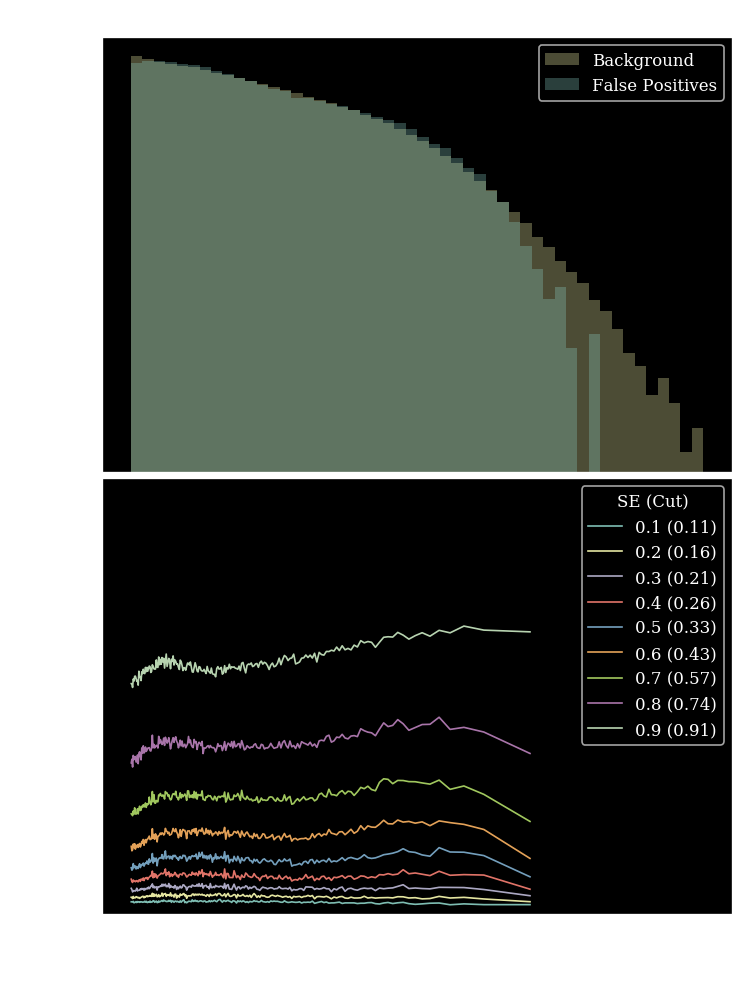

strength 60
Entering Training...
Epoch:0001/0200  (9.3  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (386.3s)
 Train: loss:0.3676, acc:68% || Val: loss: 0.0791, acc:78%, R50: 9.0779, 1/JSD: 166.0827


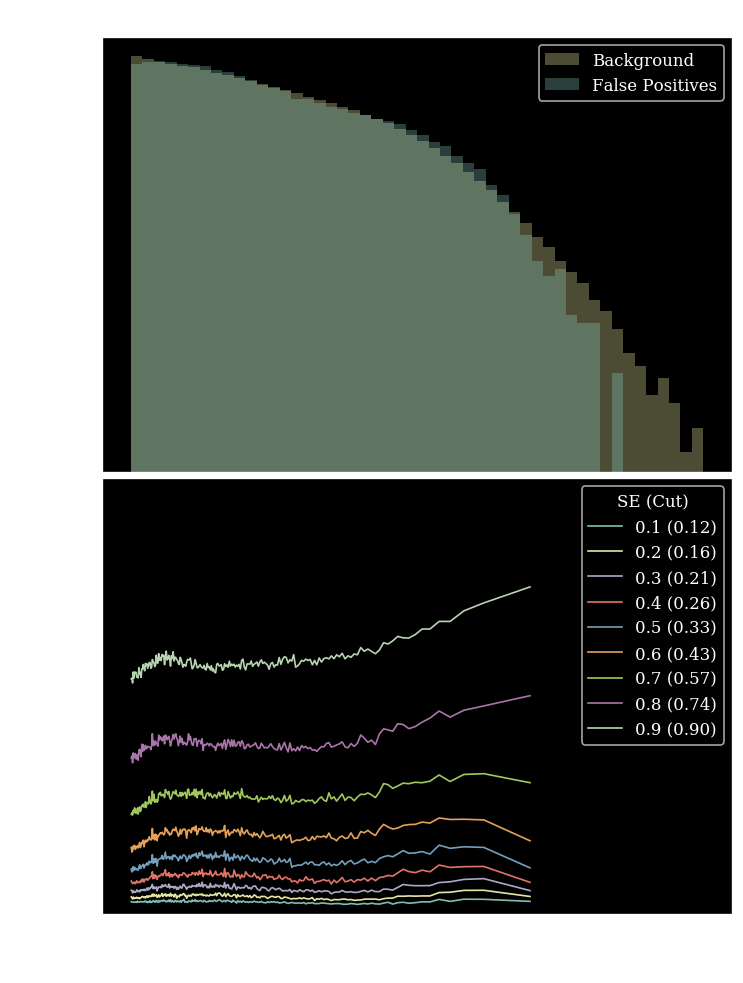

strength 60
Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (388.7s)
 Train: loss:0.3991, acc:68% || Val: loss: 0.0793, acc:79%, R50: 8.9950, 1/JSD: 230.0734


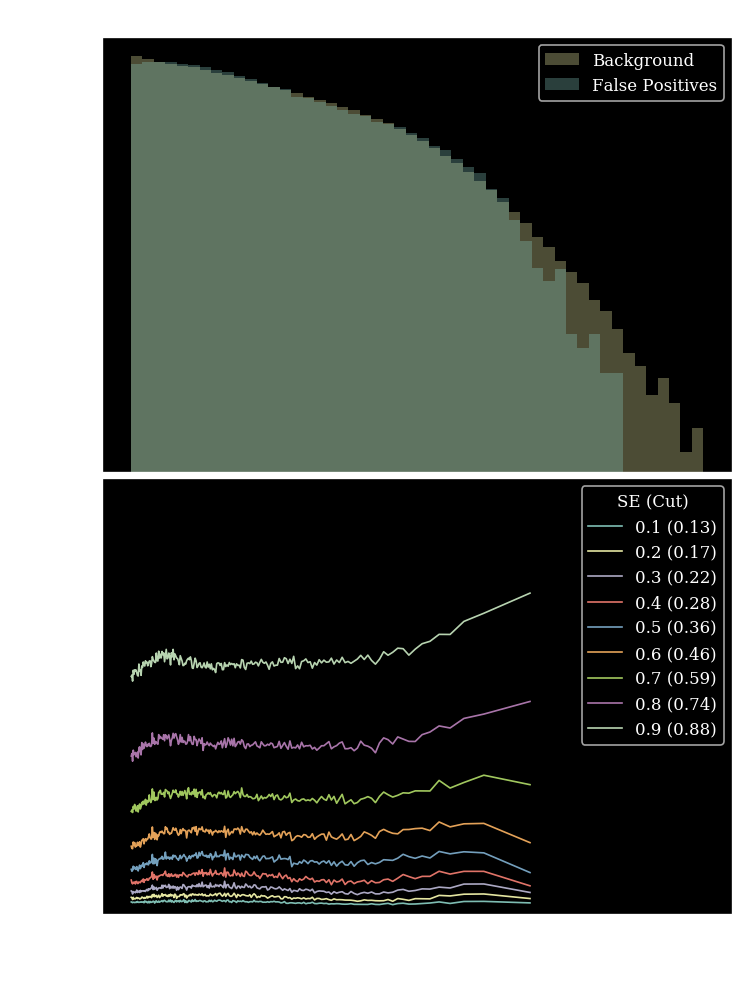

strength 75
Entering Training...
Epoch:0001/0200  (9.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (389.8s)
 Train: loss:0.3763, acc:67% || Val: loss: 0.0832, acc:78%, R50: 8.7631, 1/JSD: 297.4758


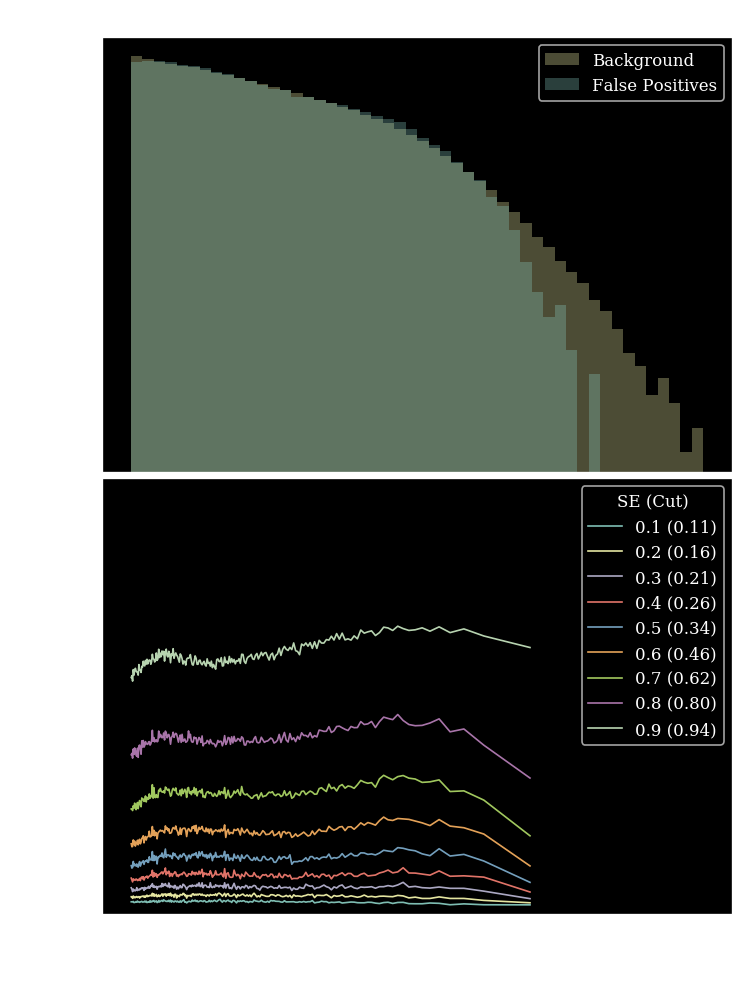

strength 75
Entering Training...
Epoch:0001/0200  (10.3 s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (391.3s)
 Train: loss:0.3859, acc:67% || Val: loss: 0.0821, acc:78%, R50: 8.8054, 1/JSD: 203.2490


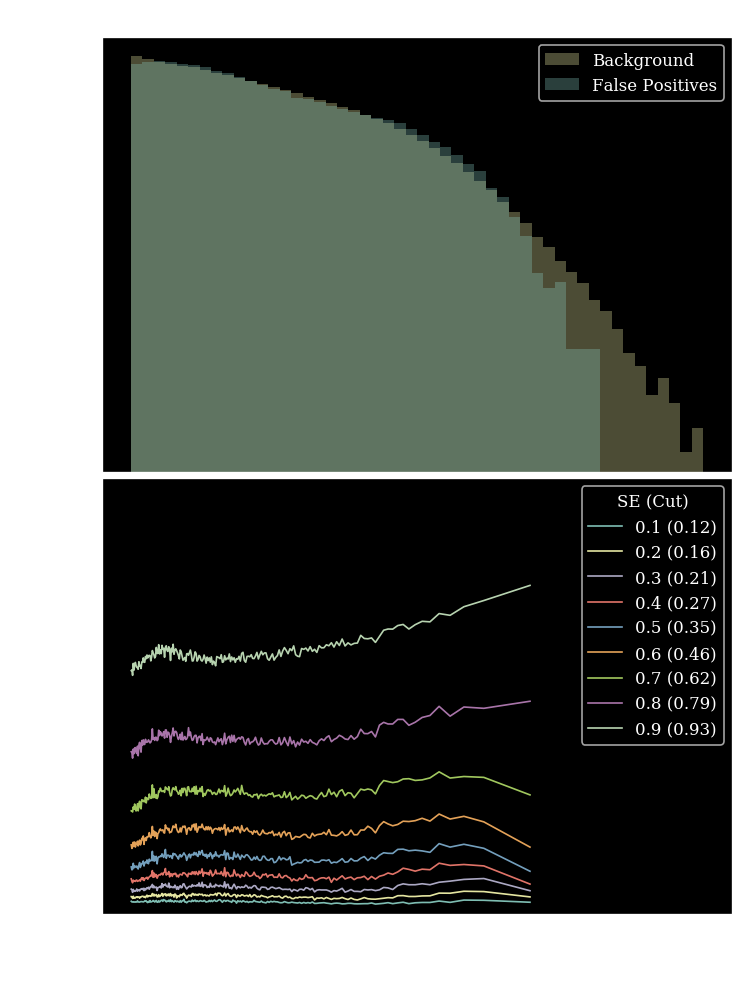

strength 75
Entering Training...
Epoch:0001/0200  (8.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (393.2s)
 Train: loss:0.4236, acc:66% || Val: loss: 0.0822, acc:79%, R50: 8.7517, 1/JSD: 233.7325


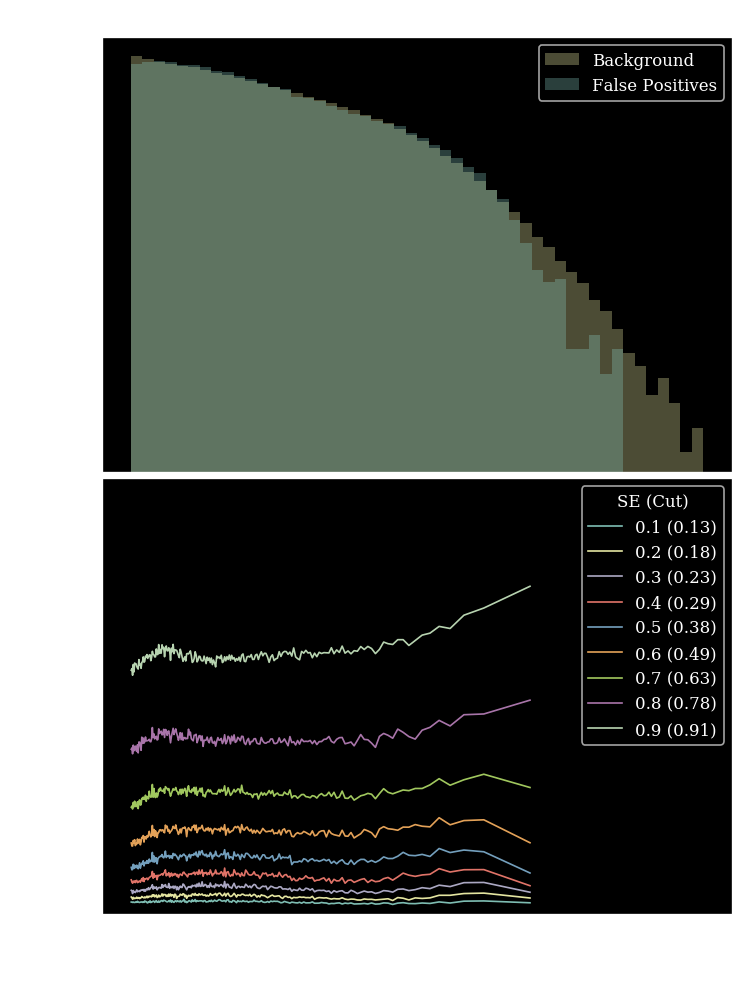

strength 85
Entering Training...
Epoch:0001/0200  (8.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (386.3s)
 Train: loss:0.3848, acc:67% || Val: loss: 0.0851, acc:79%, R50: 8.6428, 1/JSD: 328.7870


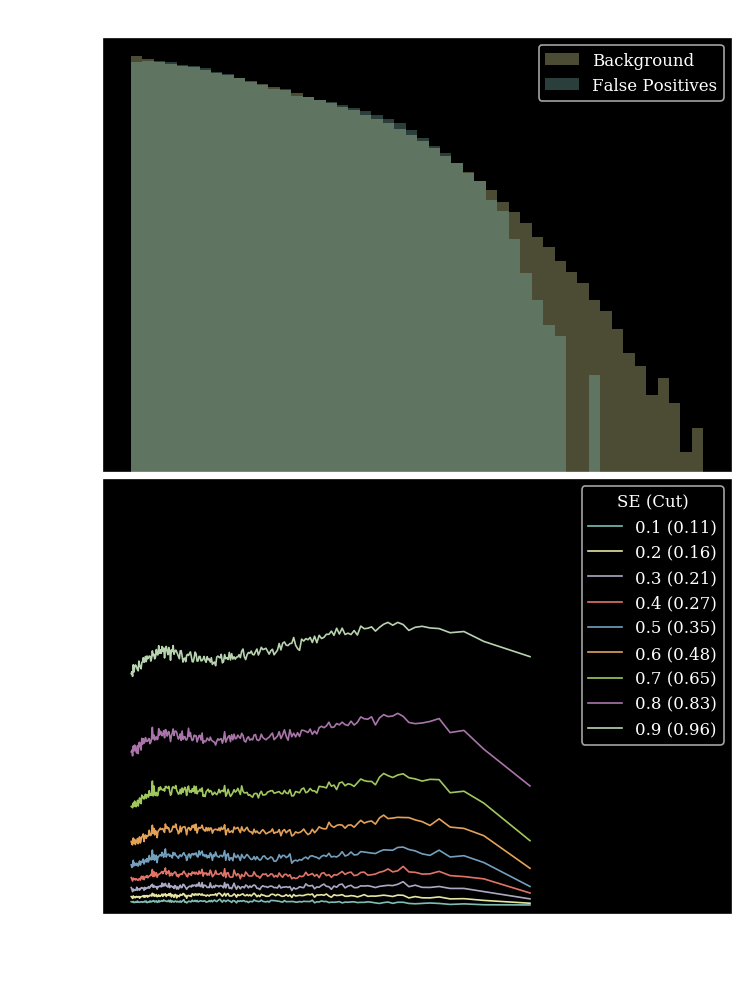

strength 85
Entering Training...
Epoch:0001/0200  (8.1  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (372.7s)
 Train: loss:0.3950, acc:67% || Val: loss: 0.0838, acc:79%, R50: 8.7083, 1/JSD: 216.1358


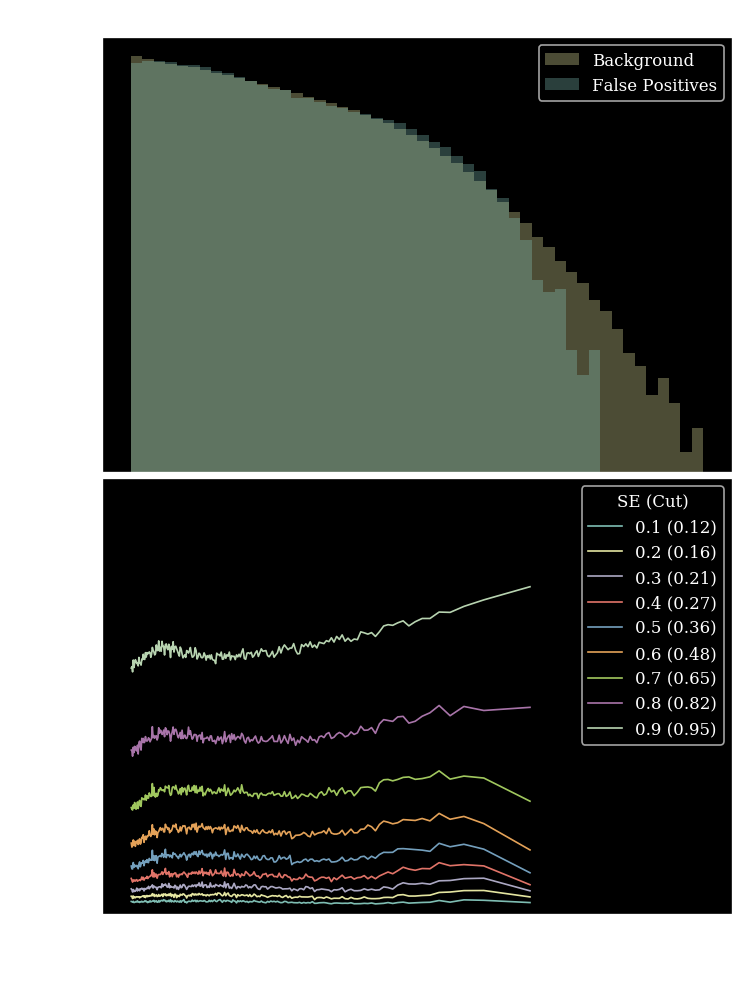

strength 85
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (375.7s)
 Train: loss:0.4353, acc:66% || Val: loss: 0.0840, acc:80%, R50: 8.6535, 1/JSD: 239.7209


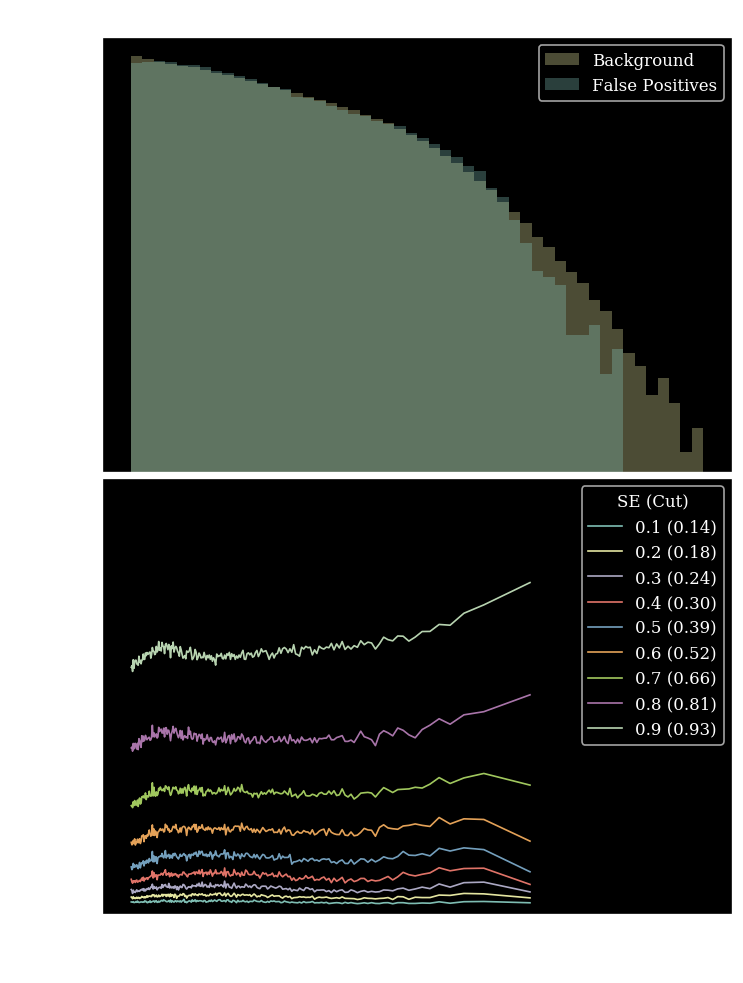

strength 100
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (398.1s)
 Train: loss:0.3944, acc:66% || Val: loss: 0.0875, acc:79%, R50: 8.5155, 1/JSD: 368.5321


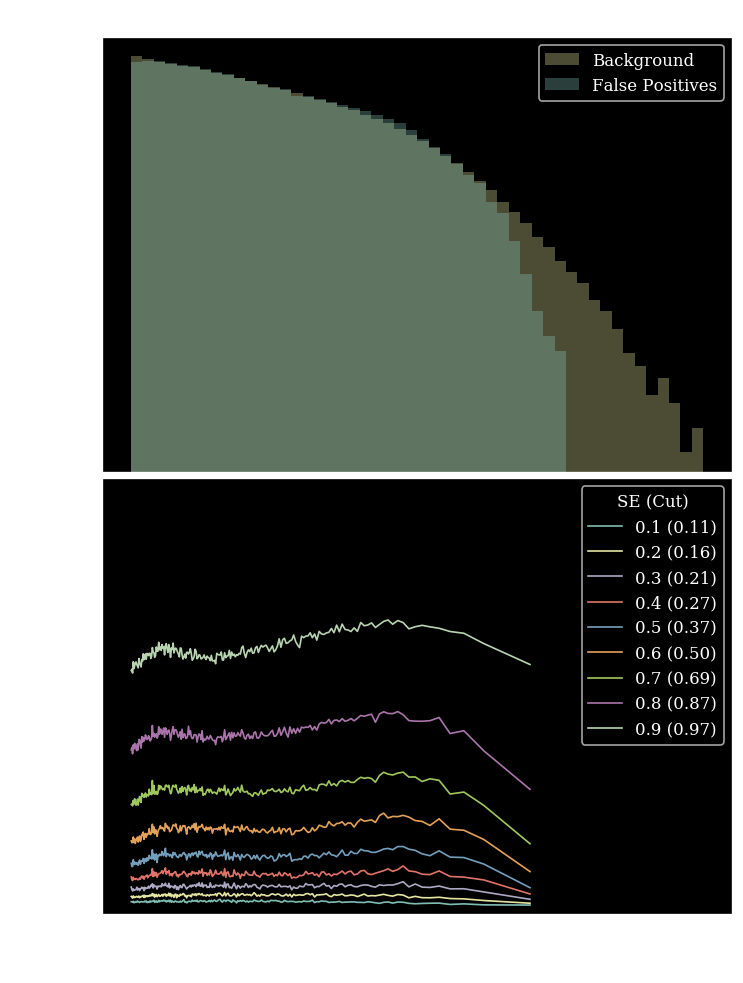

strength 100
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (377.9s)
 Train: loss:0.4066, acc:66% || Val: loss: 0.0859, acc:79%, R50: 8.5717, 1/JSD: 229.4875


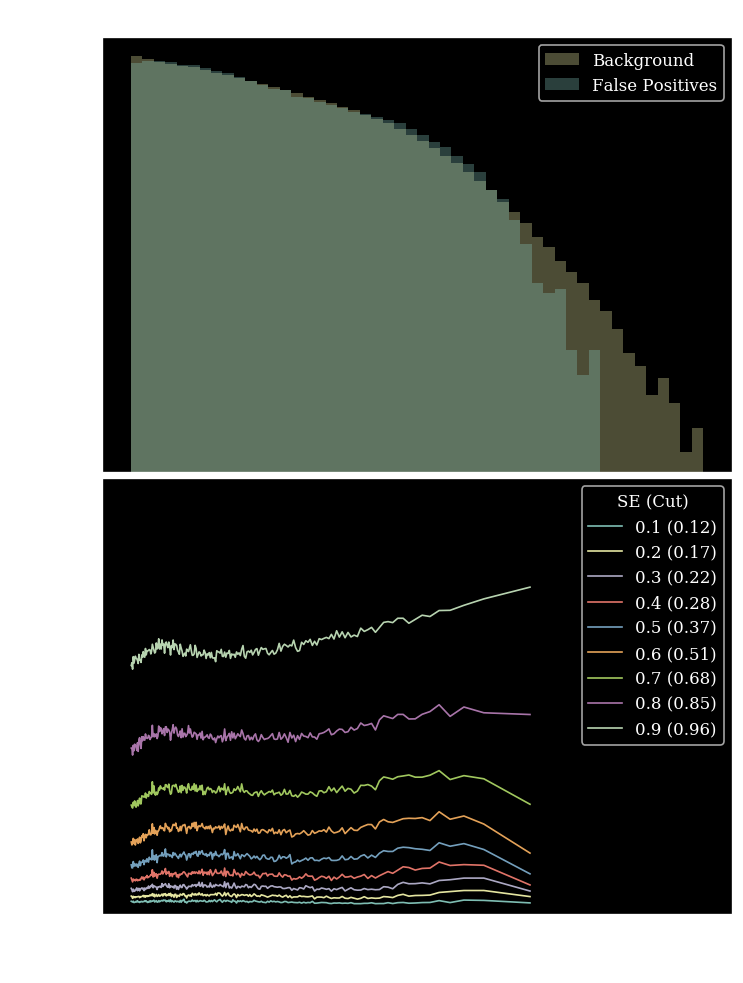

strength 100
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (377.7s)
 Train: loss:0.4544, acc:65% || Val: loss: 0.0862, acc:80%, R50: 8.5038, 1/JSD: 254.4567


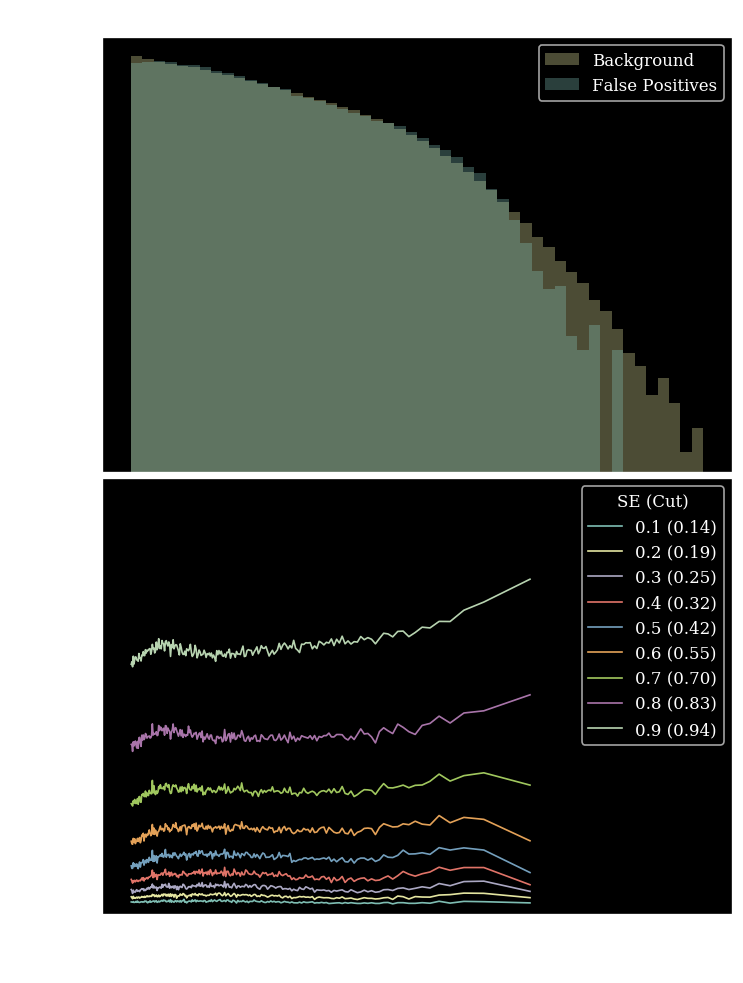

strength 110
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (377.0s)
 Train: loss:0.4008, acc:65% || Val: loss: 0.0888, acc:79%, R50: 8.4252, 1/JSD: 367.3667


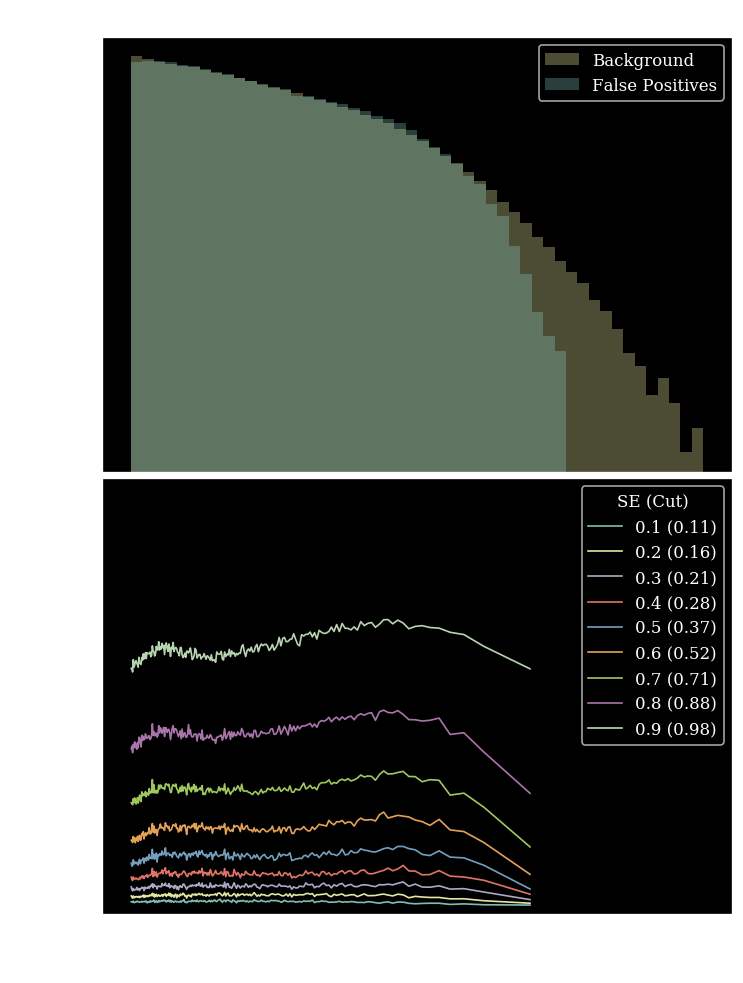

strength 110
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (371.3s)
 Train: loss:0.4140, acc:65% || Val: loss: 0.0871, acc:79%, R50: 8.4929, 1/JSD: 235.5776


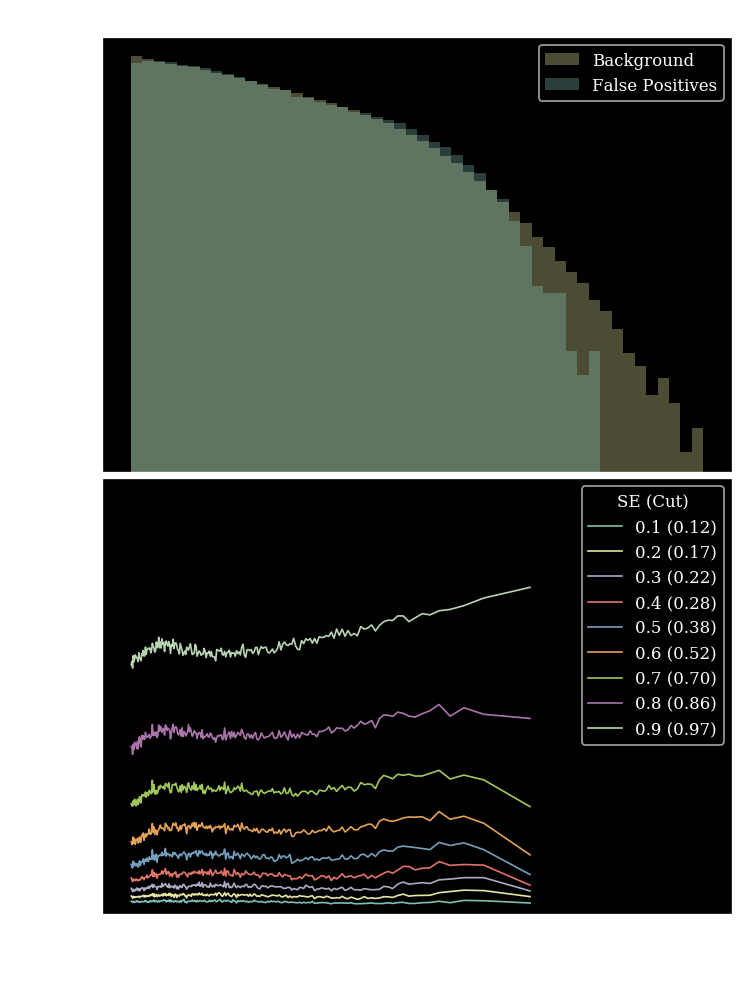

strength 110
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (370.1s)
 Train: loss:0.4658, acc:64% || Val: loss: 0.0876, acc:80%, R50: 8.4094, 1/JSD: 254.6779


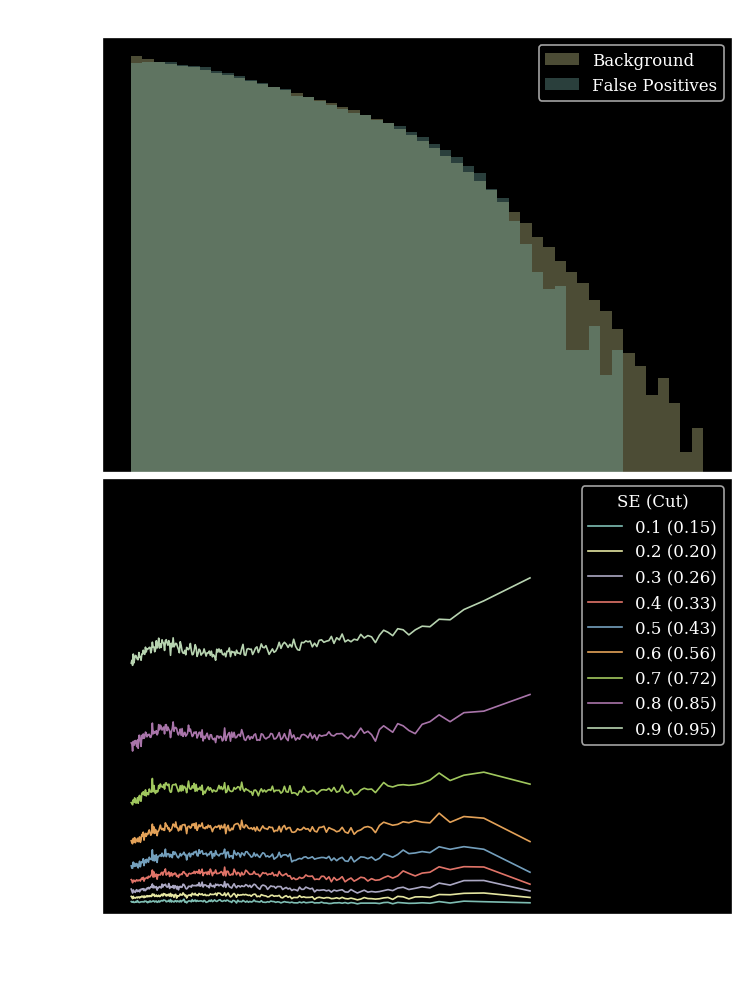

strength 120
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (371.4s)
 Train: loss:0.4068, acc:65% || Val: loss: 0.0901, acc:80%, R50: 8.3606, 1/JSD: 382.2668


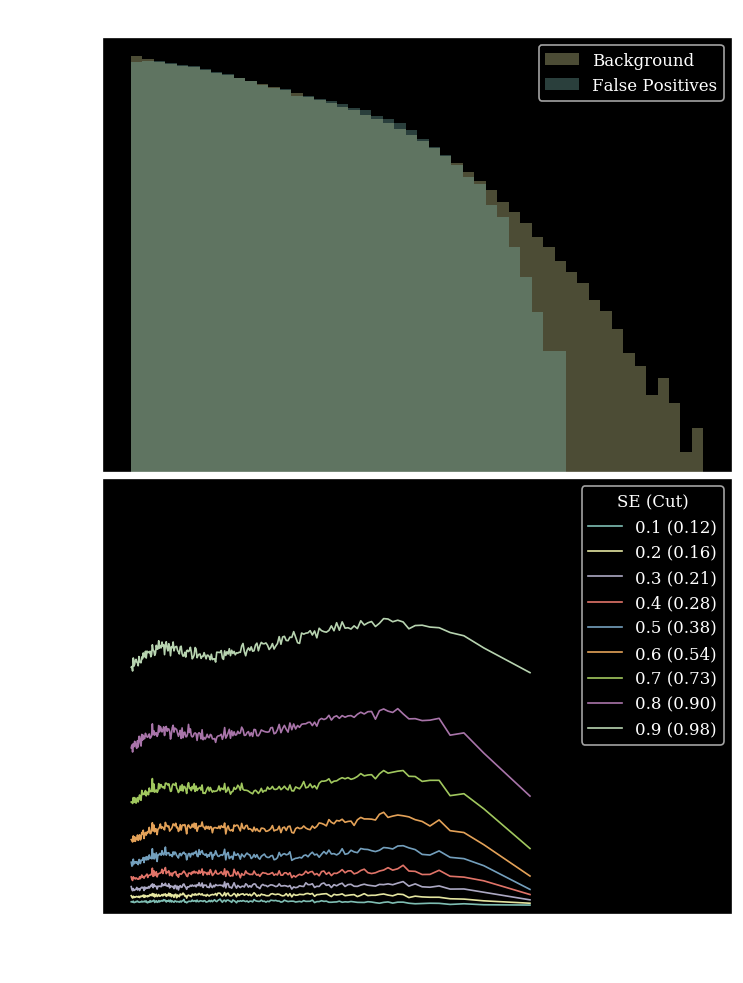

strength 120
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (368.4s)
 Train: loss:0.4209, acc:65% || Val: loss: 0.0882, acc:79%, R50: 8.4263, 1/JSD: 238.0597


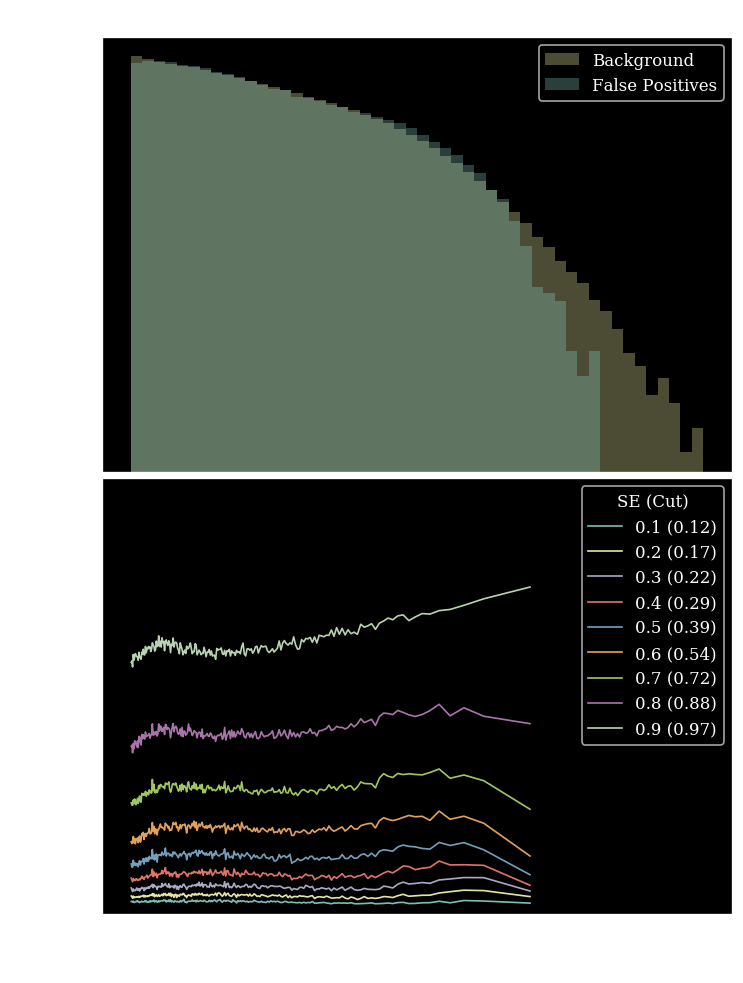

strength 120
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (369.7s)
 Train: loss:0.4775, acc:63% || Val: loss: 0.0890, acc:80%, R50: 8.3325, 1/JSD: 252.7009


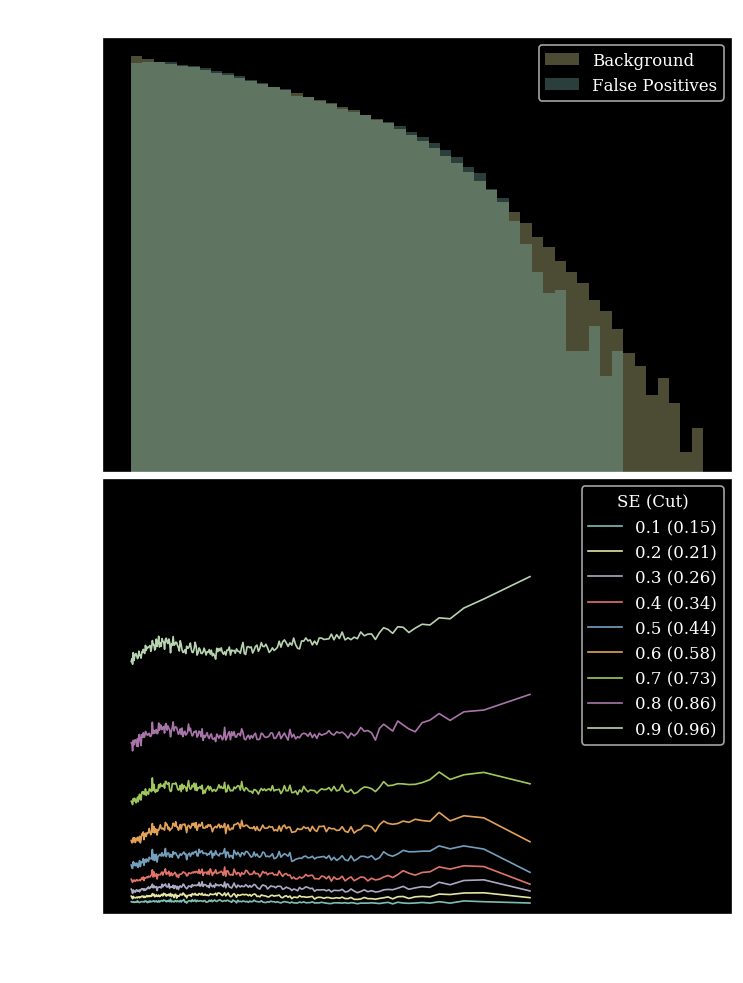

strength 200
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (370.0s)
 Train: loss:0.4444, acc:63% || Val: loss: 0.0970, acc:80%, R50: 7.9953, 1/JSD: 286.7259


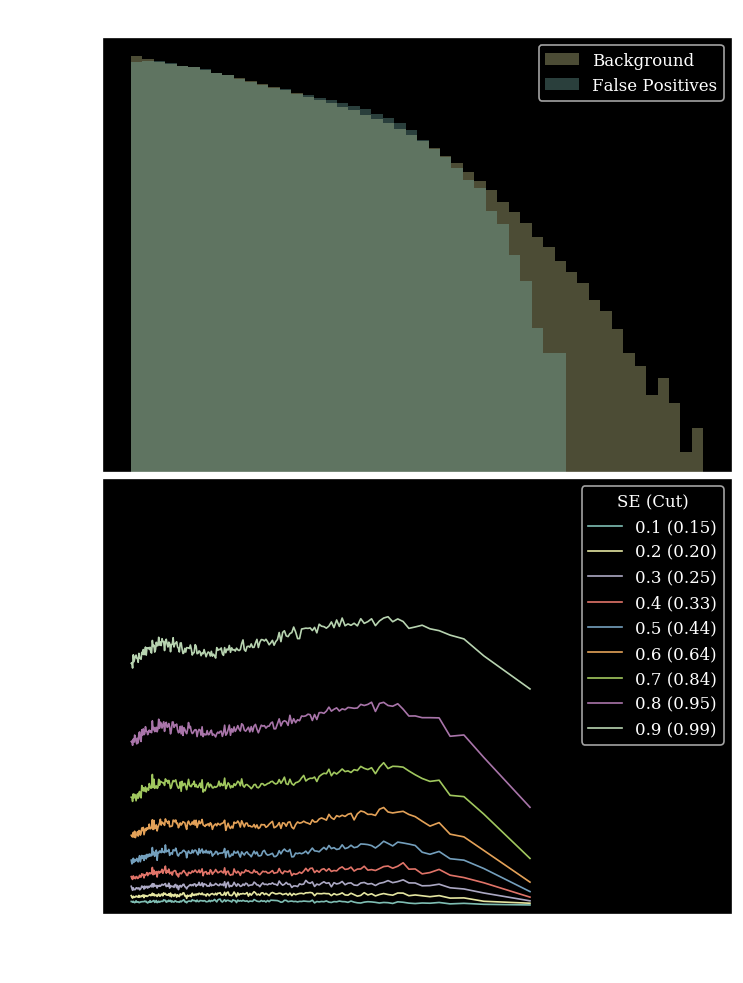

strength 200
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (369.1s)
 Train: loss:0.4695, acc:62% || Val: loss: 0.0954, acc:80%, R50: 8.0509, 1/JSD: 276.9854


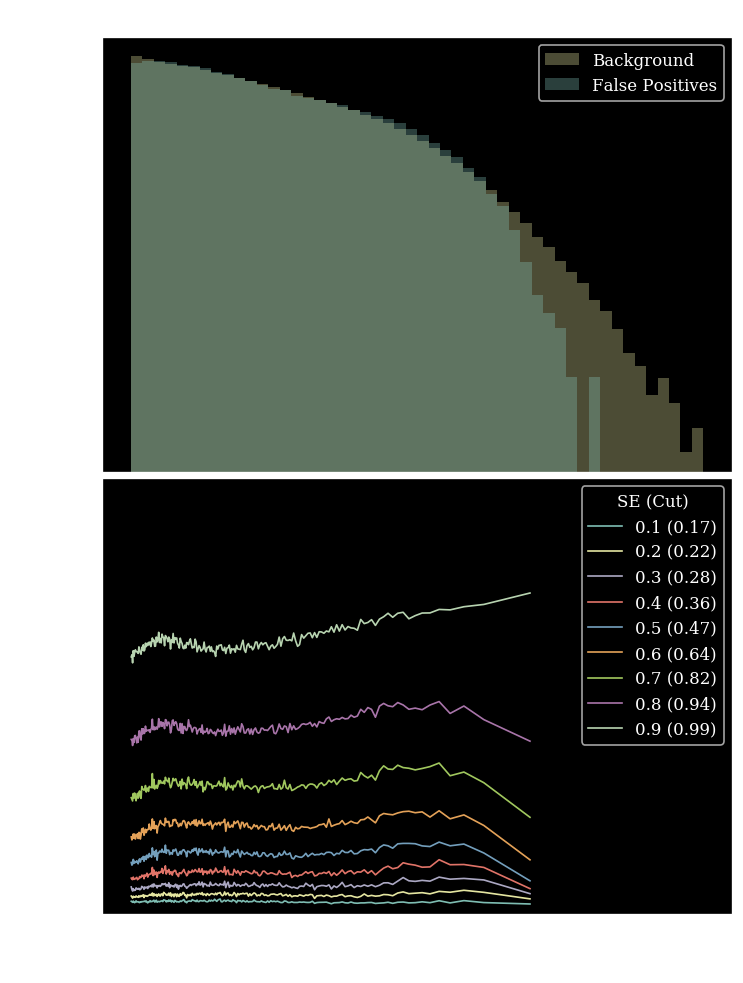

strength 200
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (369.7s)
 Train: loss:0.5526, acc:59% || Val: loss: 0.0983, acc:82%, R50: 8.0732, 1/JSD: 304.1063


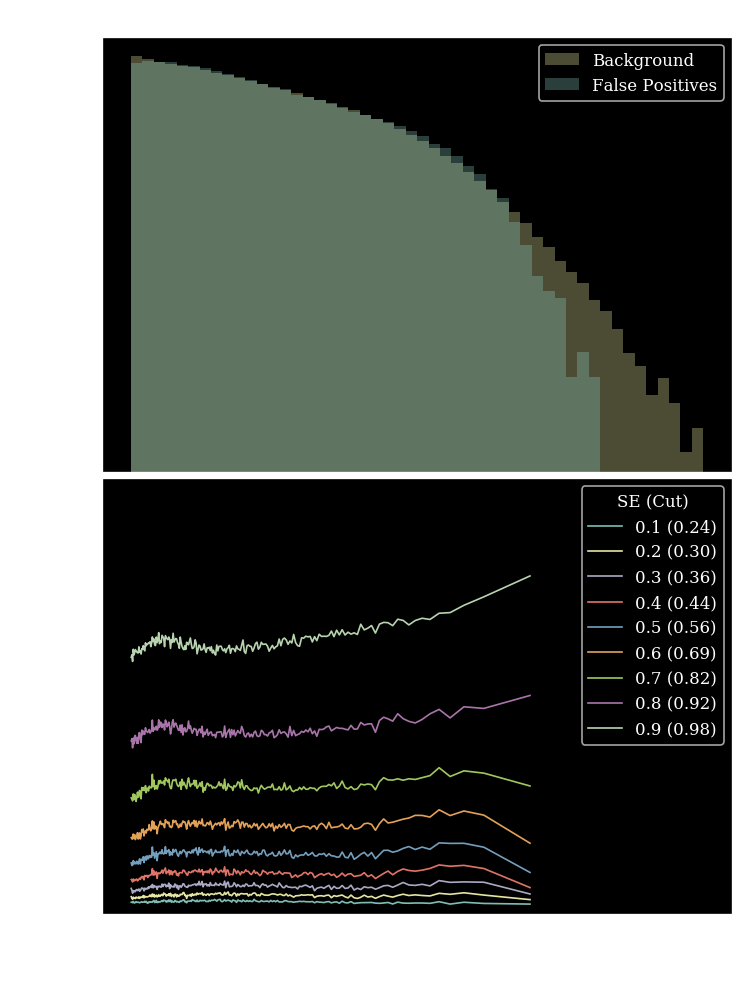

strength 500
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (370.7s)
 Train: loss:0.5452, acc:53% || Val: loss: 0.1149, acc:82%, R50: 7.2380, 1/JSD: 218.7885


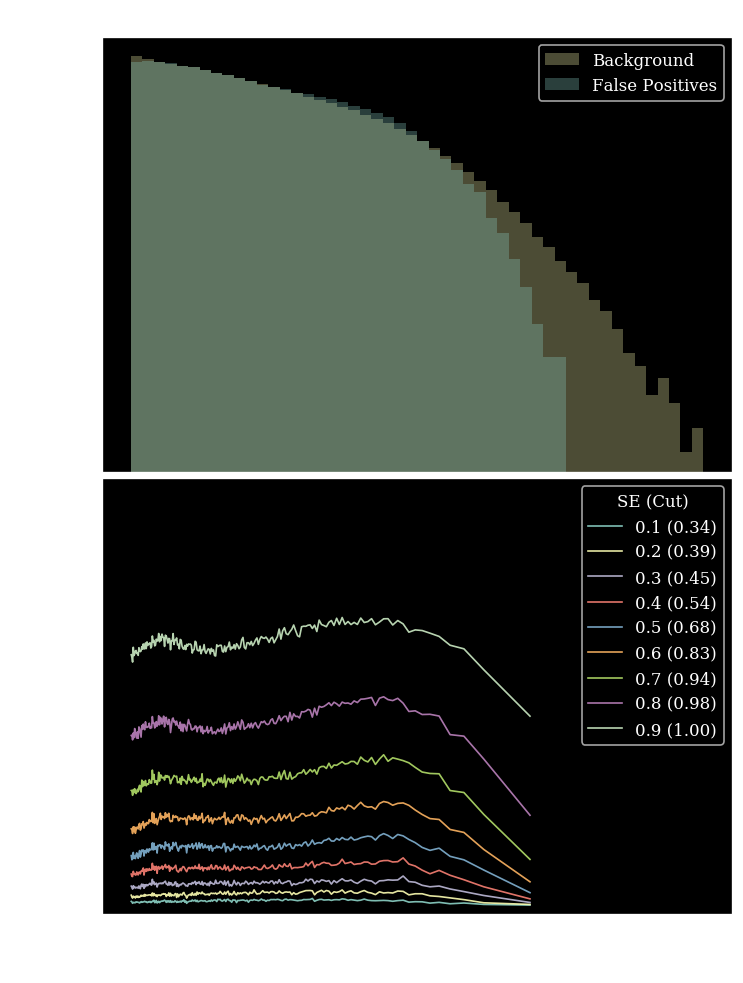

strength 500
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (376.8s)
 Train: loss:0.5963, acc:47% || Val: loss: 0.1189, acc:82%, R50: 7.0492, 1/JSD: 297.4119


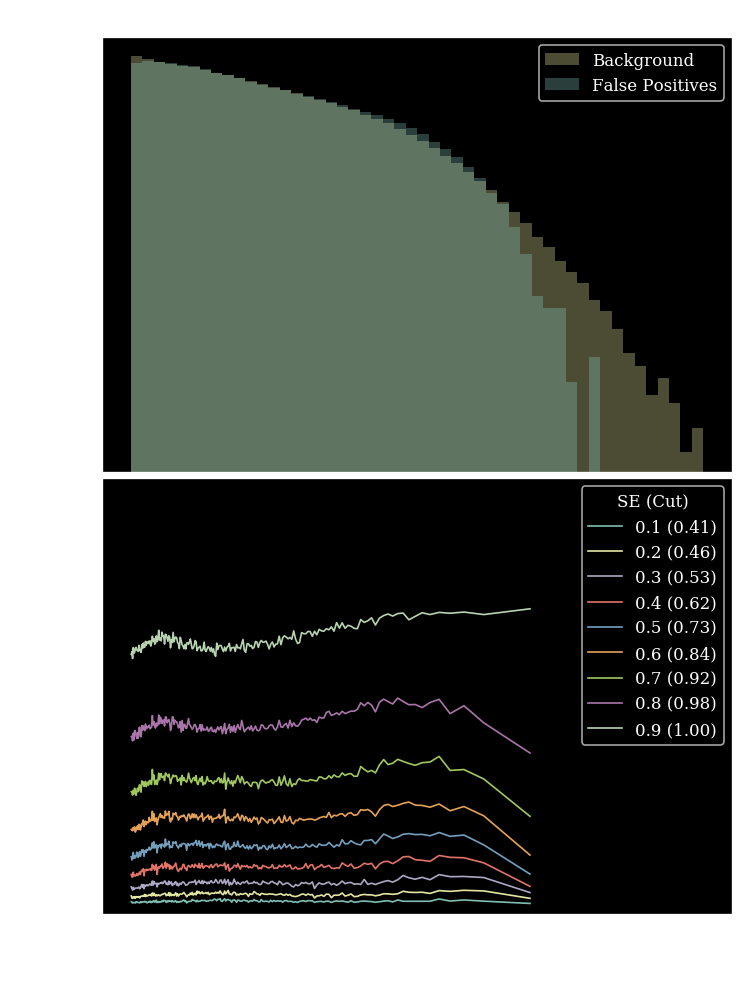

strength 500
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (377.6s)
 Train: loss:0.7080, acc:31% || Val: loss: 0.1330, acc:81%, R50: 7.2056, 1/JSD: 346.1811


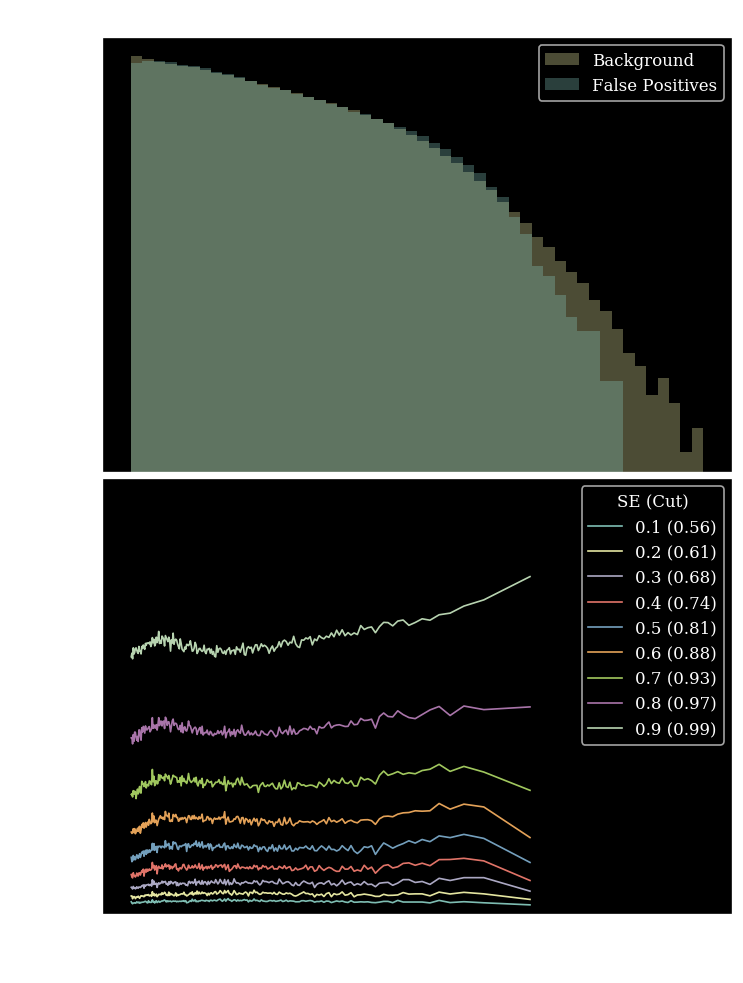

strength 1000
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (376.2s)
 Train: loss:0.6519, acc:31% || Val: loss: 0.1419, acc:81%, R50: 6.3689, 1/JSD: 141.4512


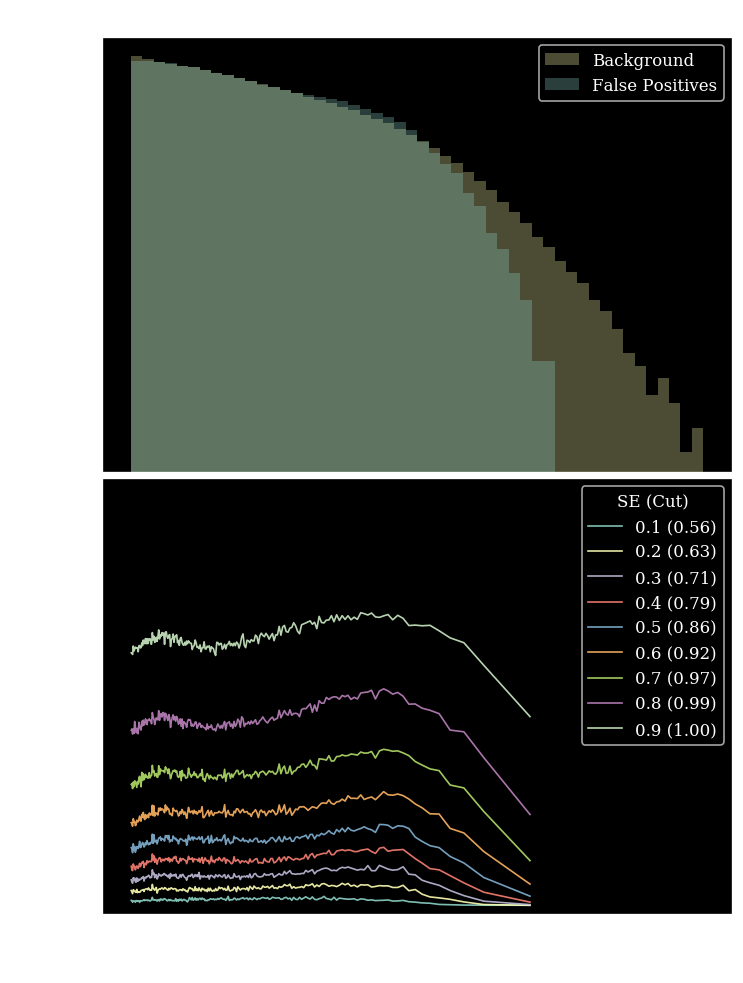

strength 1000
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (378.5s)
 Train: loss:0.7043, acc:31% || Val: loss: 0.1443, acc:80%, R50: 6.4187, 1/JSD: 315.9907


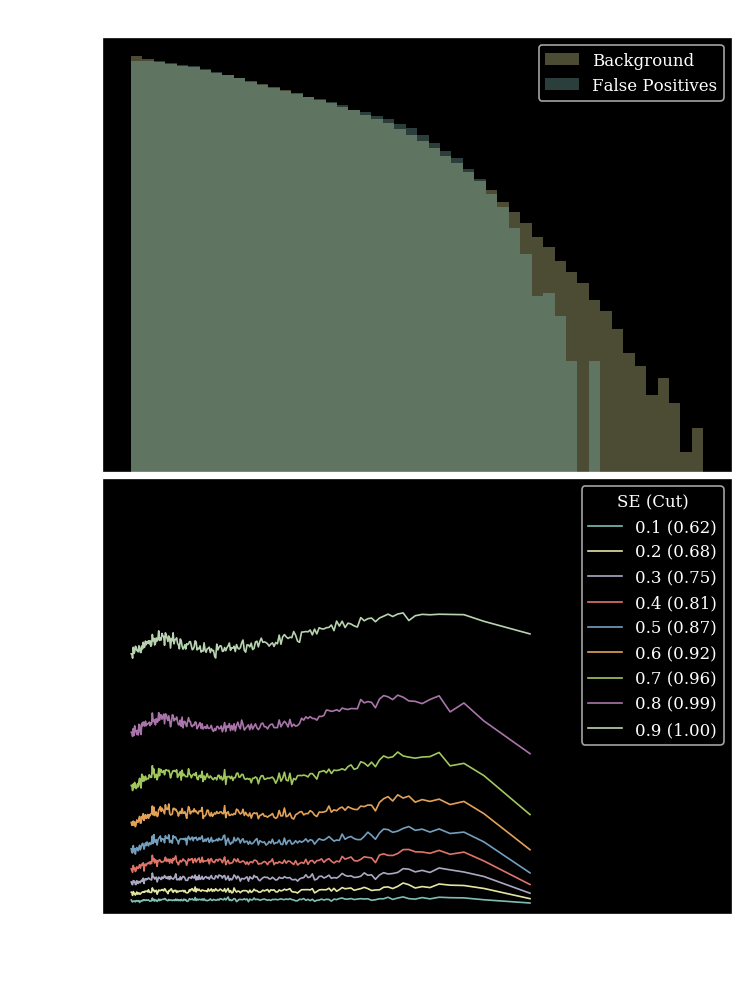

strength 1000
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (377.4s)
 Train: loss:0.7932, acc:31% || Val: loss: 0.1597, acc:80%, R50: 6.6196, 1/JSD: 389.5909


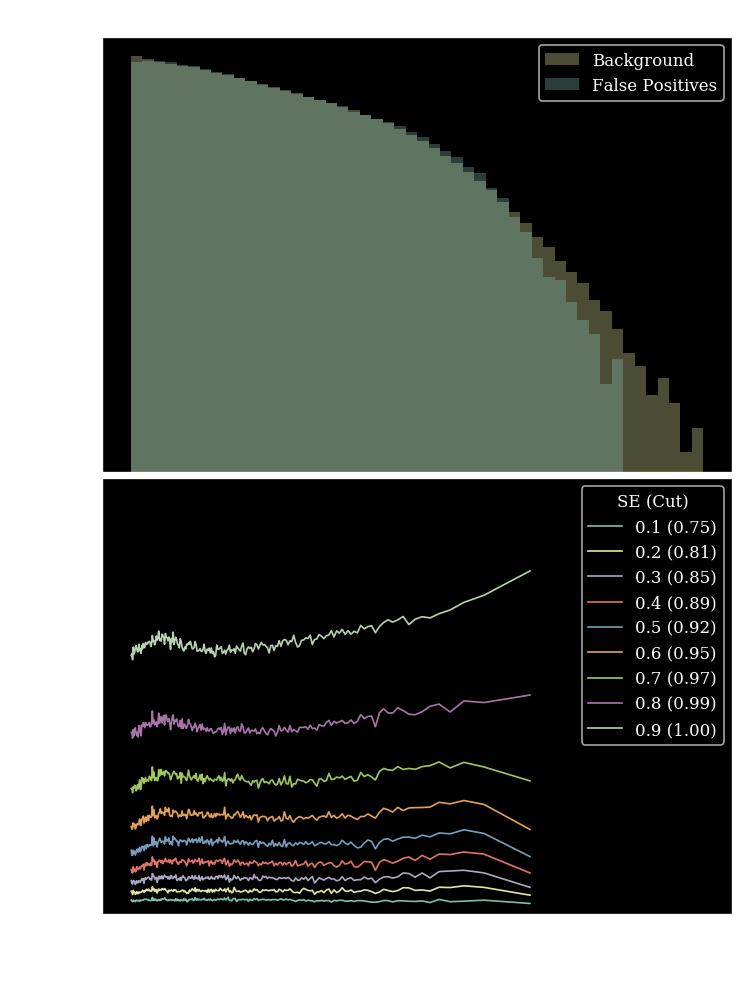

In [8]:
jsdR50flatstr = []
for i,frac in enumerate([1,50,60,75,85,100,110,120,200,500,1000]):
    for bins in [5,10,32]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=False)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatstr.append(out)

# DisCo str

strength 1
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (605.1s)
 Train: loss:0.2170, acc:78% || Val: loss: 0.0615, acc:82%, R50: 18.4347, 1/JSD: 3.4411


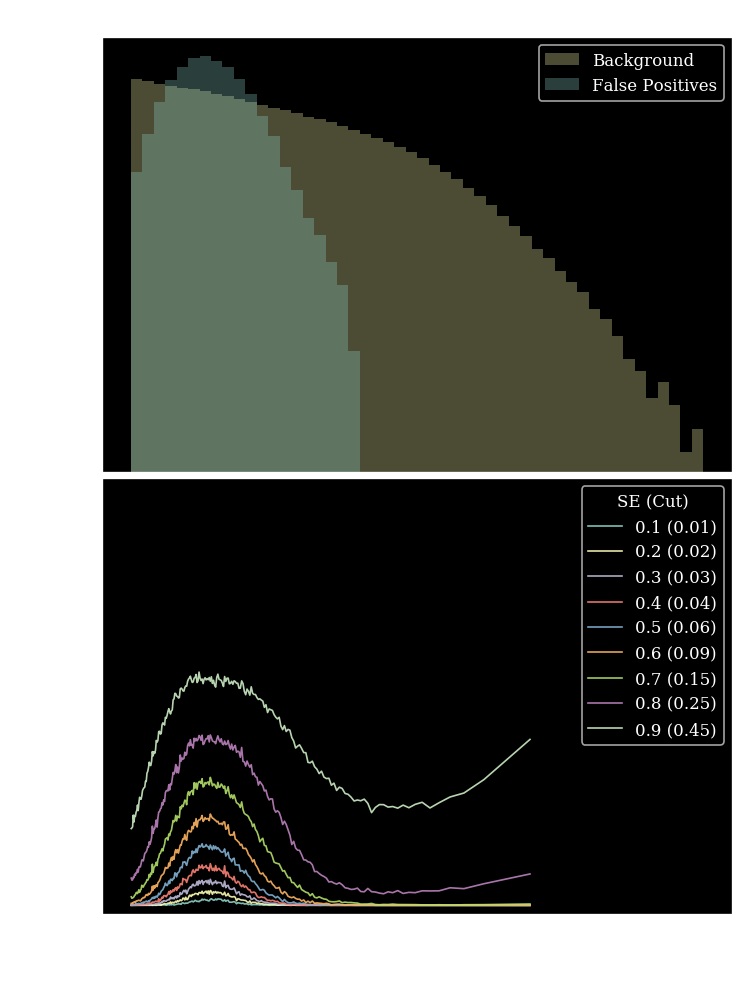

strength 2
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (607.7s)
 Train: loss:0.2311, acc:76% || Val: loss: 0.0646, acc:79%, R50: 14.0467, 1/JSD: 9.7882


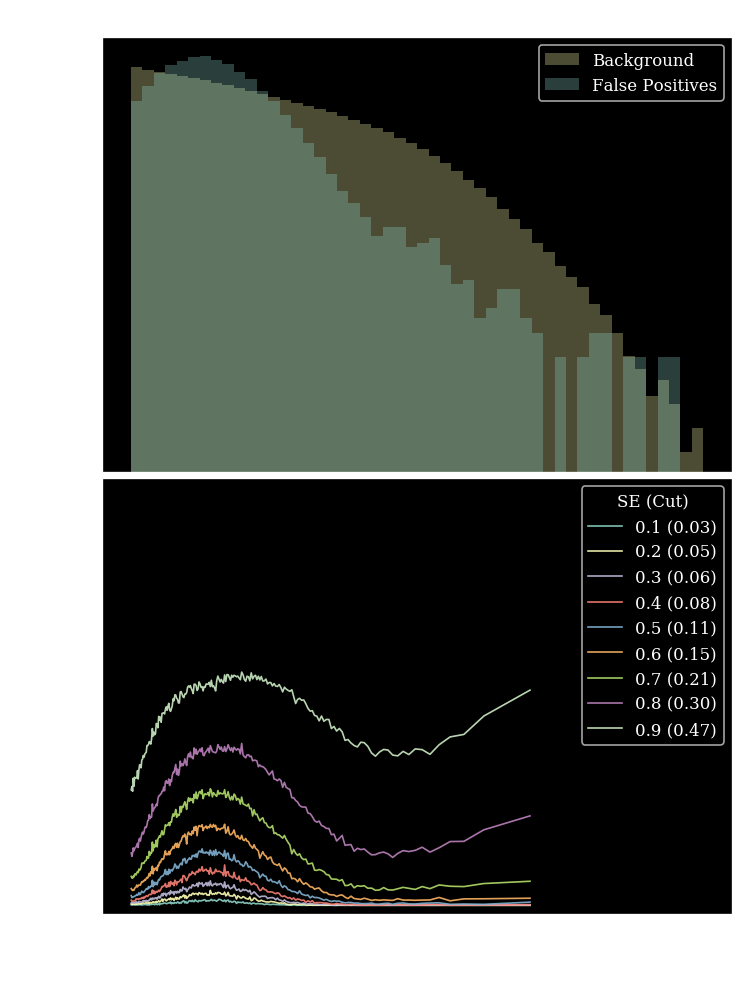

strength 5
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (626.3s)
 Train: loss:0.2565, acc:71% || Val: loss: 0.0721, acc:76%, R50: 9.2132, 1/JSD: 100.4004


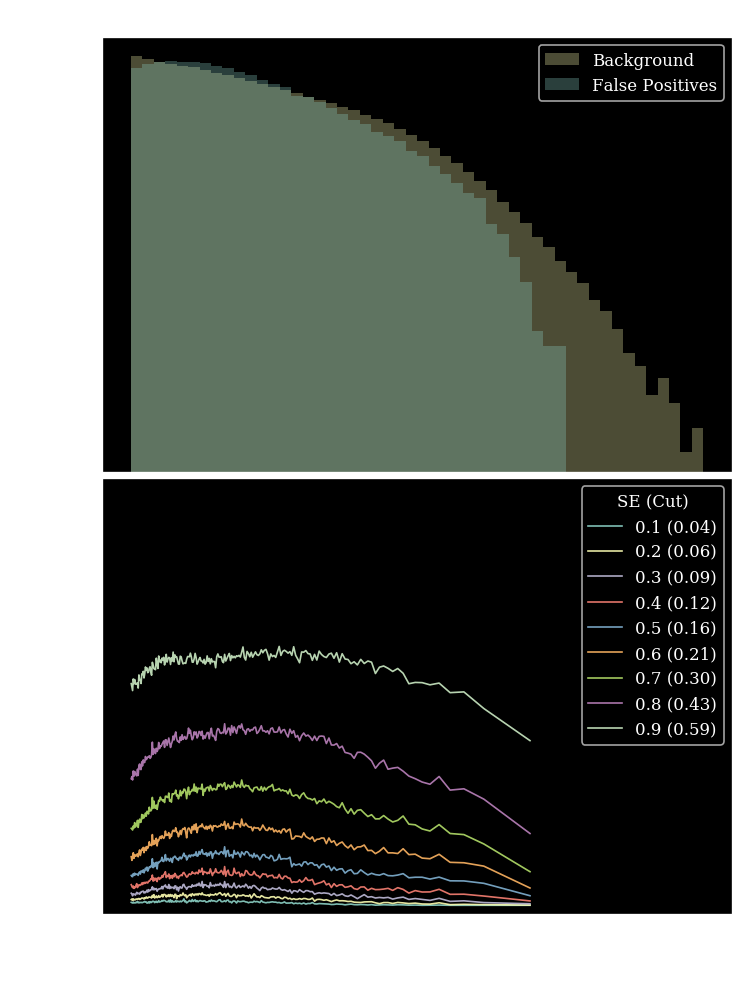

strength 10
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (616.8s)
 Train: loss:0.2728, acc:70% || Val: loss: 0.0764, acc:75%, R50: 8.3359, 1/JSD: 272.2909


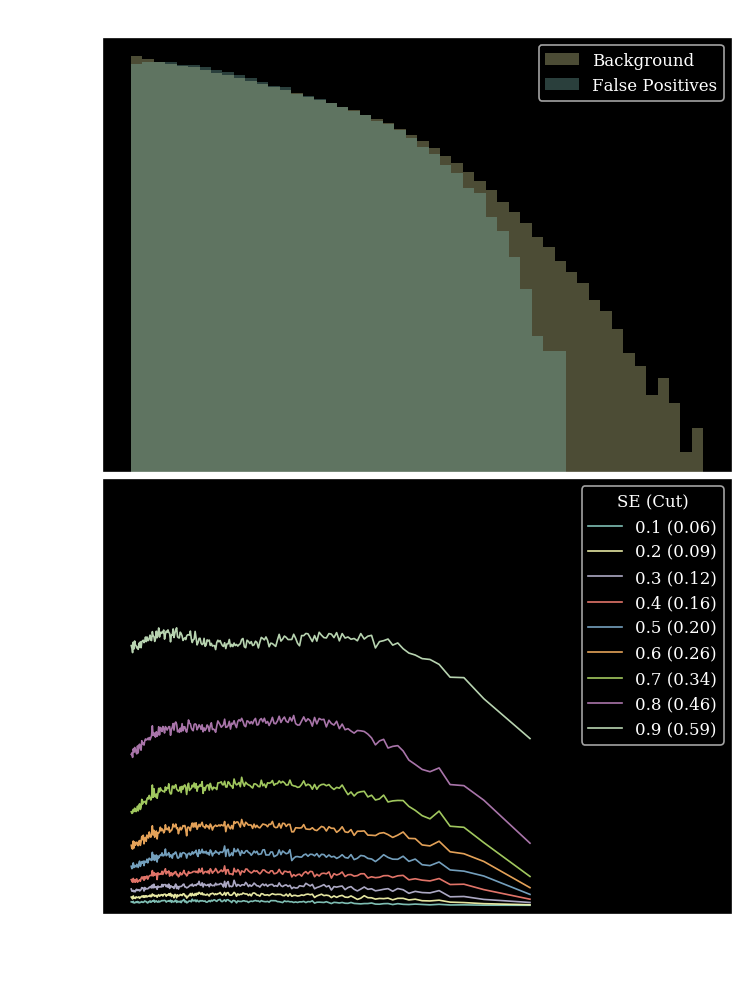

strength 20
Entering Training...
Epoch:0001/0200  (8.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (619.2s)
 Train: loss:0.3130, acc:68% || Val: loss: 0.0871, acc:72%, R50: 6.5954, 1/JSD: 564.8666


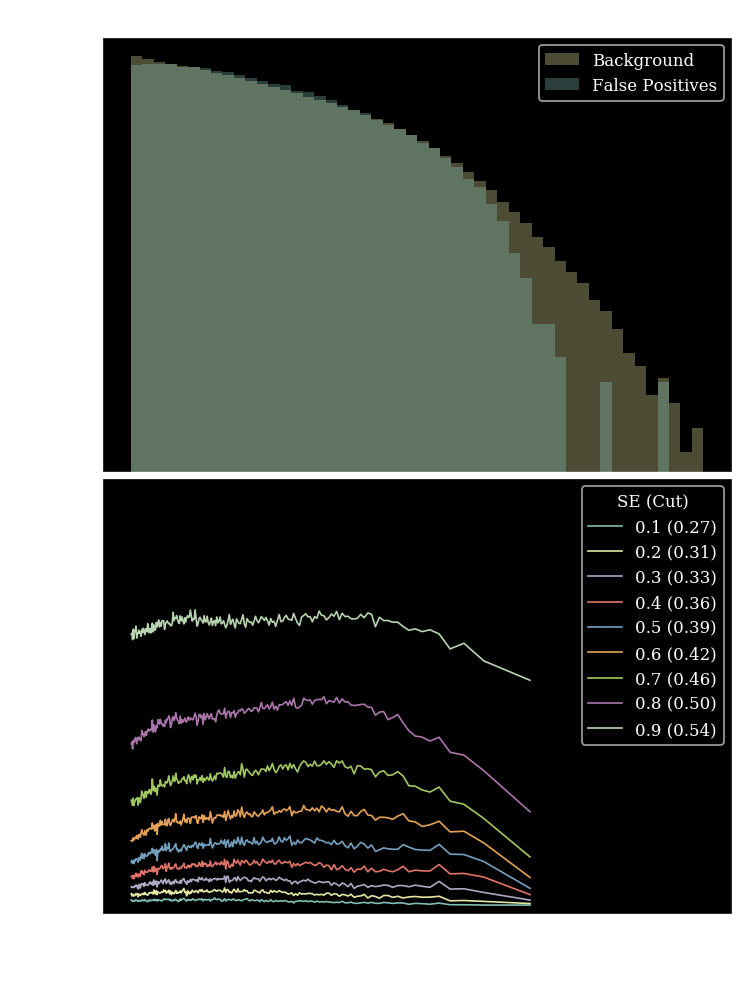

strength 30
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (625.2s)
 Train: loss:0.3320, acc:64% || Val: loss: 0.0916, acc:70%, R50: 4.8512, 1/JSD: 978.0048


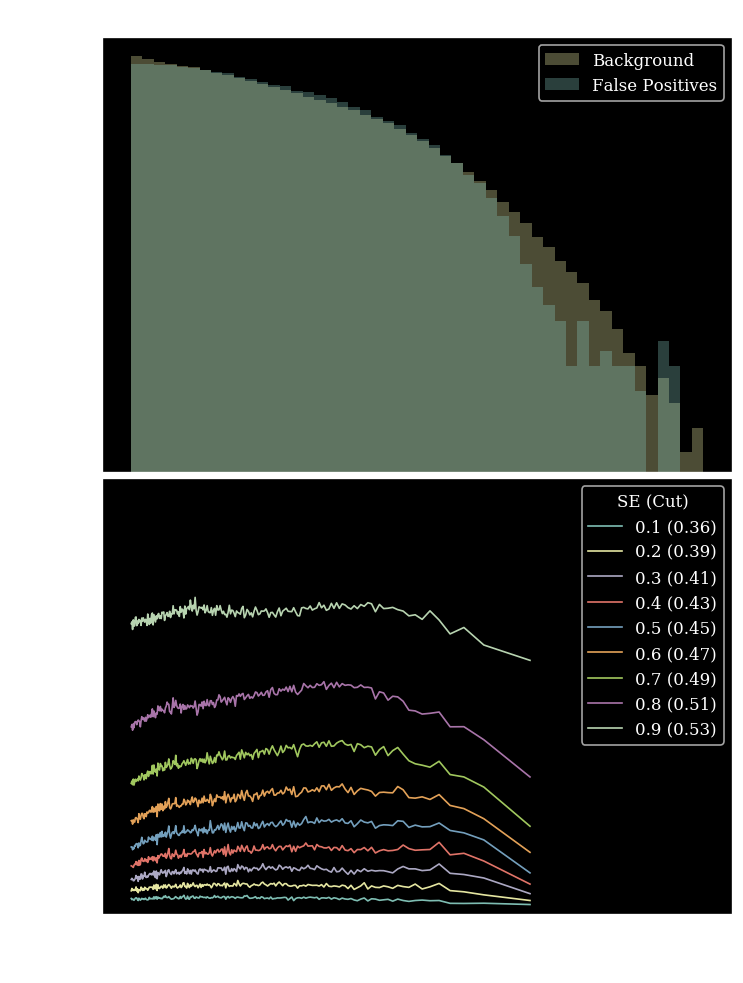

strength 50
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (620.4s)
 Train: loss:0.3436, acc:60% || Val: loss: 0.0942, acc:67%, R50: 3.6615, 1/JSD: 1745.0830


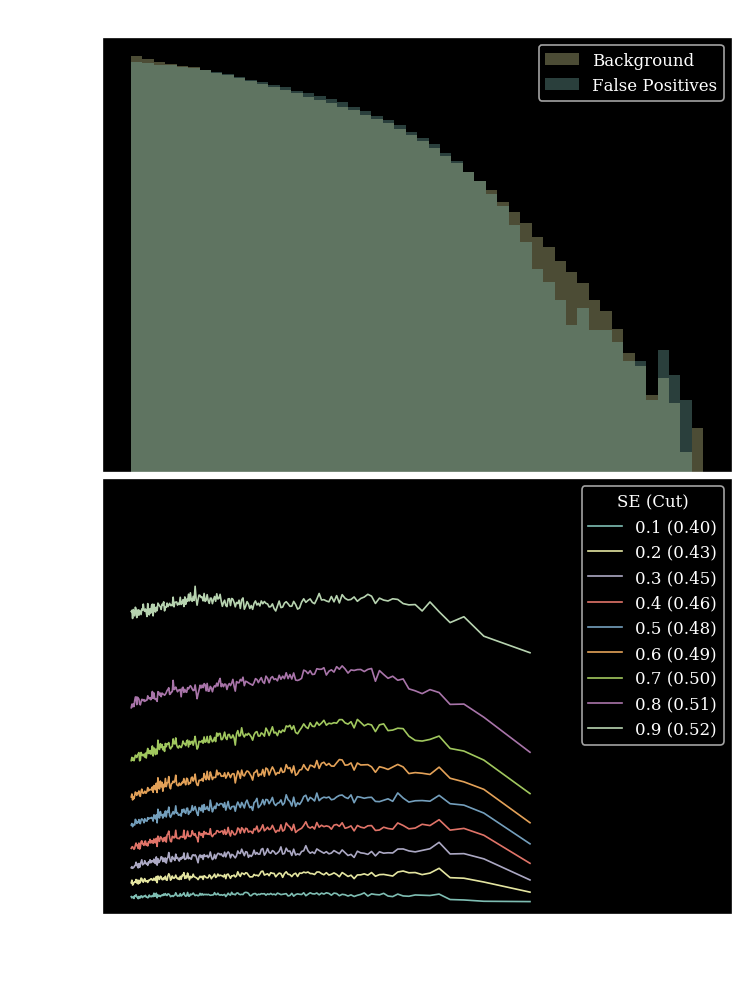

strength 100
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (605.3s)
 Train: loss:0.3583, acc:55% || Val: loss: 0.0957, acc:64%, R50: 2.9282, 1/JSD: 1902.1054


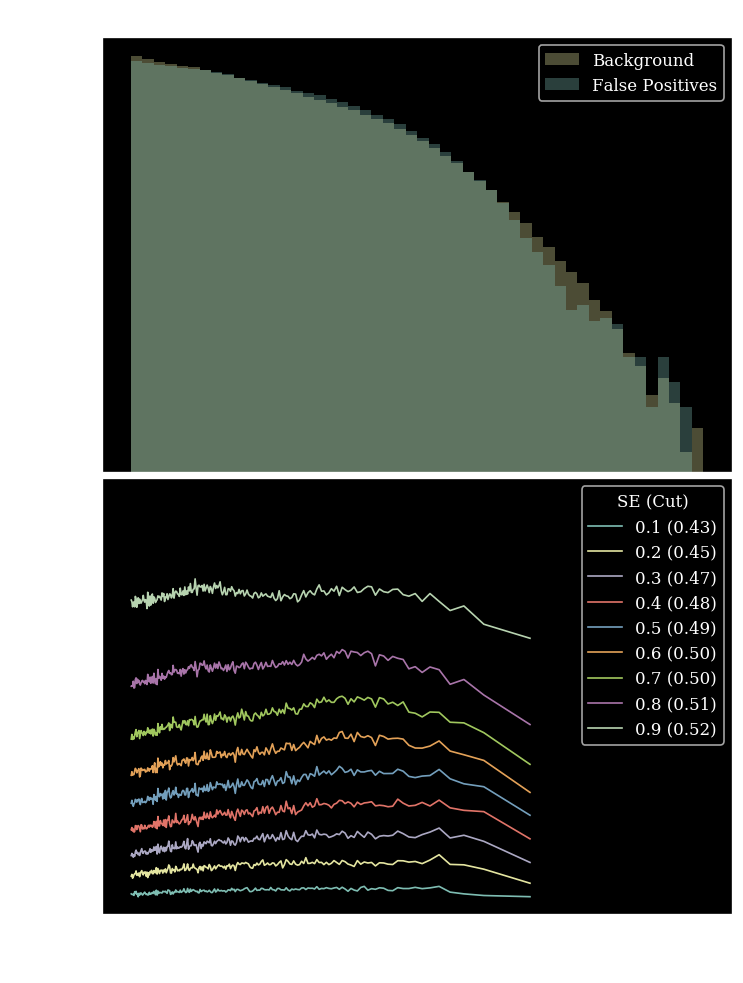

strength 200
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (607.0s)
 Train: loss:0.3736, acc:53% || Val: loss: 0.0965, acc:61%, R50: 2.5795, 1/JSD: 1775.0473


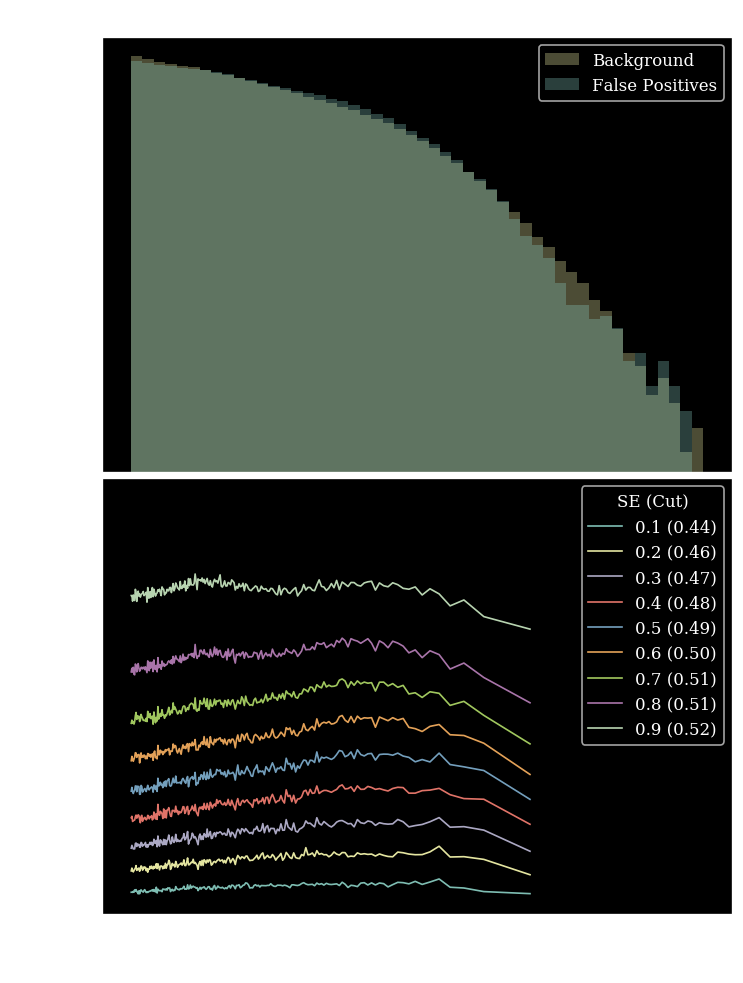

strength 300
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (606.4s)
 Train: loss:0.3876, acc:52% || Val: loss: 0.0967, acc:60%, R50: 2.4754, 1/JSD: 1868.8687


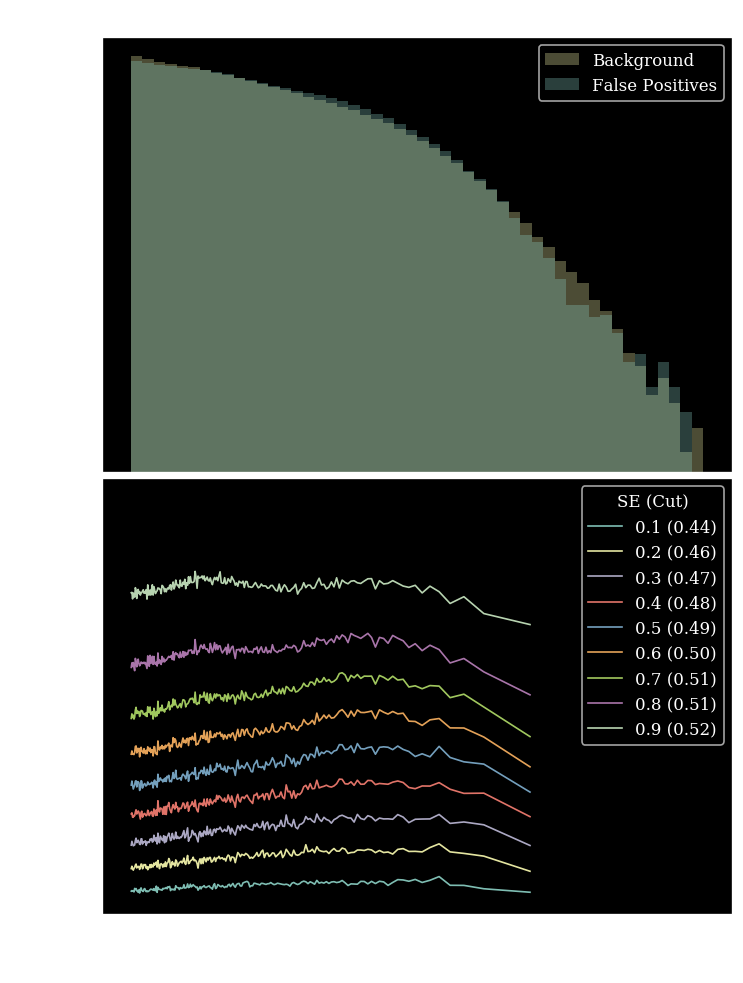

strength 1000
Entering Training...
Epoch:0001/0200  (8.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810
Epoch:0200/0200  (655.7s)
 Train: loss:0.4881, acc:54% || Val: loss: 0.0970, acc:55%, R50: 2.3505, 1/JSD: 2023.0709


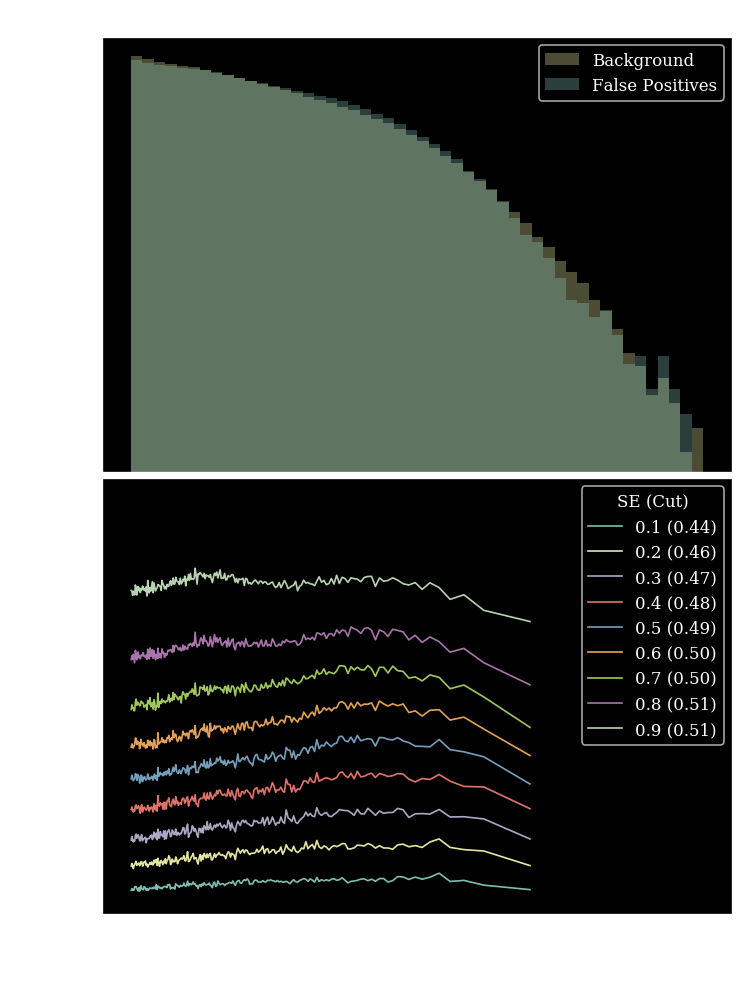

In [7]:
jsdR50Disco = []
for i,frac in enumerate([1,2,5,10,20,30,50,100,200,300,1000]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    log=Logger("./logs/logWFCNDisLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"DisCo DNN str:{frac}",X=X,
                   y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
    jsdR50Disco.append(out)

Text(0, 0.5, '1/JSD')

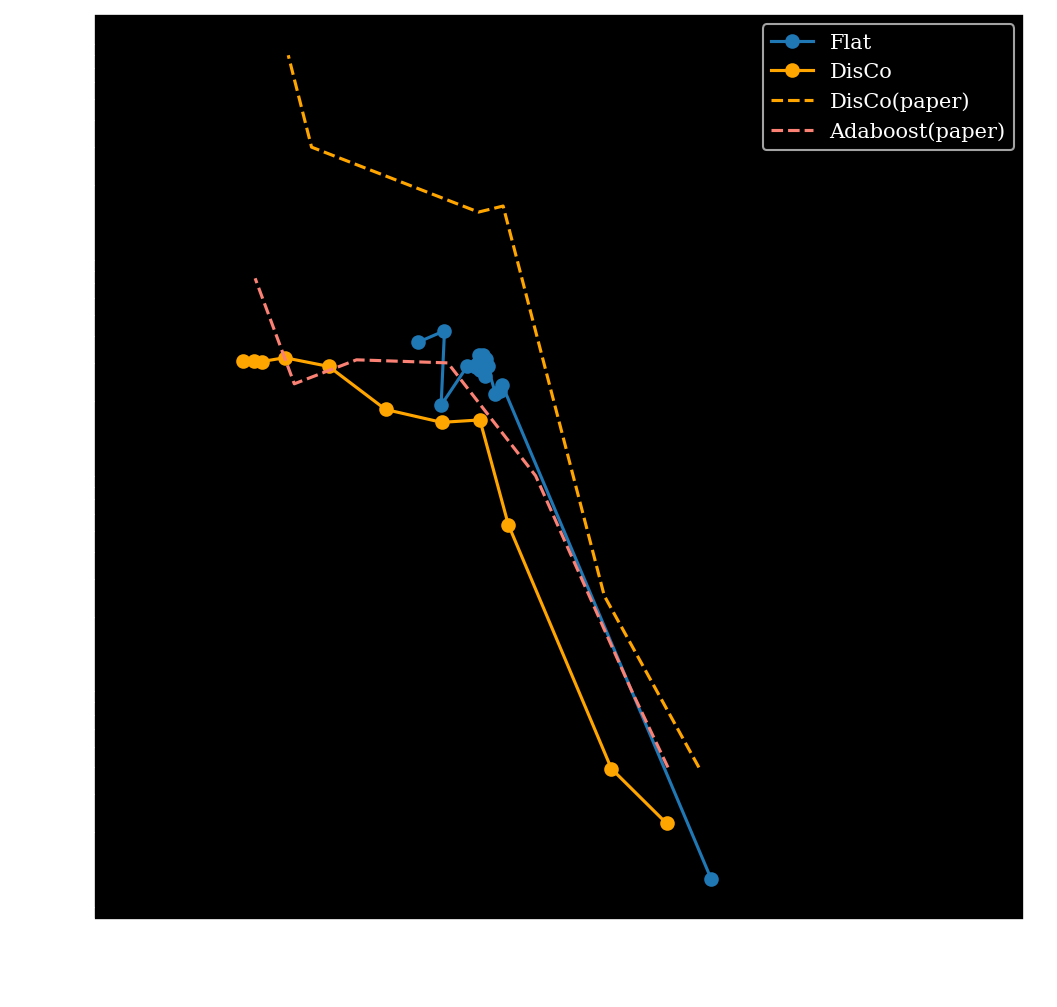

In [14]:
JSD,R50 = zip(*jsdR50flatstr[1::2])
JSDa,R50a = zip(*jsdR50flatstr[0::2])
JSDb,R50b = zip(*jsdR50flatstr[2::2])
JSD2,R502 = zip(*jsdR50Disco)
JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat',c='tab:blue')
#plt.errorbar(R50a,JSDa,fmt='-o',label='Flat')
#plt.errorbar(R50b,JSDb,fmt='-o',label='Flat')
plt.errorbar(R502,JSD2,fmt='-o',label='DisCo',c='orange')
plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right')
plt.xlabel('R50')
plt.ylabel('1/JSD')

# Flat with global memory 

In [ ]:
device = 'cpu'
params['device'] = device

jsdR50flatstrMem = []
for i,frac in enumerate([1,50,60,75,85,100,110,120,200,500,1000]):
    for bins in [5,10]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=True)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatstrMem.append(out)

In [ ]:
device = 'cpu'
params['device'] = device

jsdR50flatstrMem = []
for i,frac in enumerate([1,50,60,75,85,100,110,120,200,500,1000]):
    for bins in [5,10]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,memory=True)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatstrMem.append(out)

strength 1
Entering Training...
Epoch:0001/0200  (4.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0976, acc:80%, R50: 1.7307, 1/JSD: 60.8810


# No MSE loss test 

In [ ]:
jsdR50flatNA = []
for i,frac in enumerate([1,10,100]):
    for bins in [5,10,32,64,70,100]:
        print("strength",frac)
        metrics_train_L = Metrics()
        metrics_val_L = Metrics(validation=True)

        torch.manual_seed(777)
        model_L = Classifier().to(device)
        optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-4)
        loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins,msefrac=0,memory=True)
        log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
        model_L.fit(traindataset=traindataset,
                    valdataset=valdataset,
                    optimizer=optimizer,
                    loss=loss,
                    **params,
                    log=log,
                  #scheduler=scheduler,
                  metrics=[metrics_train_L,metrics_val_L])
        model_L.train(False)
        out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,
                       y=test_labels,x_biased=test[:,0],mbins=200,histbins=50)
        jsdR50flatNA.append(out)

In [ ]:
jsdR50flatstr

In [ ]:
jsdR50flatstrMem

In [ ]:
jsdR50Disco

In [ ]:
JSD,R50 = zip(*jsdR50flatstr[0::2])
JSD10,R5010 = zip(*jsdR50flatstrMem[0::3])
JSD11,R5011 = zip(*jsdR50flatstrMem[1::3])
JSD12,R5012 = zip(*jsdR50flatstrMem[2::3])
JSD2,R502 = zip(*jsdR50Disco)

JSD3 = np.array([4,25,1.6e3,1.5e3,3e3,8e3])
R503 = [23,15,9.5,8.5,4,3.6]
JSD4 = [4,9,90,300,310,240,740]
R504 = [20,17,11,7.4,4.9,3.7,3.1]
    
fig, ax= plt.subplots(1,1,figsize=(8,8),dpi=150)
plt.errorbar(R50,JSD,fmt='-o',label='Flat',c='tab:blue')
#plt.errorbar(R5010,JSD10,fmt='-o',label='Flat-Global',c='tab:purple')
plt.errorbar(R5011,JSD11,fmt='-o',label='Flat-Global',c='C4')
#plt.errorbar(R5012,JSD12,fmt='-o',label='Flat-Global',c='tab:red')
plt.errorbar(R502,JSD2,fmt='-o',label='DisCo',c='orange')
#plt.errorbar(R503,JSD3,fmt='--',label='DisCo(paper)',c='orange',ls='--')
#plt.errorbar(R504,JSD4,fmt='--',label='Adaboost(paper)',c='C3',ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1.5,100])
#plt.ylim([1,1.3e5])
plt.legend(loc='upper right')
plt.xlabel('R50')
plt.ylabel('1/JSD')

In [ ]:
asdf adsf 

# Untrained model

In [ ]:
jsd_r50

In [ ]:
jsd_r50

In [ ]:
preds = np.array(model_L(X).tolist()).flatten()
#plt.hist(preds,bins=50,density=True,log=True)
plt.hist(preds[test_labels==0],bins=50,density=True,log=True,alpha=0.5)
plt.hist(preds[test_labels==1],bins=50,density=True,log=True,alpha=0.5)
plt.gcf().set_dpi(120)
plt.show()

# 2n point long time

In [ ]:
params['epochs'] = 1000
for i,bins in enumerate([20]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

In [ ]:
params['epochs'] = 300
params['interval'] = 20
model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

In [ ]:
es = np.arange(0,11)*100
fig =plt.gcf()
fig, ax1 = plt.subplots(dpi=120,figsize=(10,8))

color = 'orange'
ax1.set_xlabel('epochs')
ax1.set_ylabel('R50', color=color)
ax1.errorbar(es, metrics_val_L.R50[:11], color=color,fmt="-o")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('1/JSD', color=color)  # we already handled the x-label with ax1
ax2.errorbar(es, 1/np.array(metrics_val_L.JSD[:11]), color=color,fmt="-o")
ax2.tick_params(axis='y', labelcolor=color,)

plt.show()

In [ ]:
#as a function of bins
jsd_r50 = list()
for i,bins in enumerate([10,20,30,50,80]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

    del model_L
    torch.cuda.empty_cache()
    jsd_r50.append(out)

In [ ]:
#as a function of bins
jsd_r50 = list()
for i,bins in enumerate([100,110,115,120,125,128,130,135,140,150]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    model_L.train(False)
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=X,y=test_labels,x_biased=test[:,0])

    del model_L
    torch.cuda.empty_cache()
    jsd_r50.append(out)

# As a function of bins

In [ ]:
#as a function of bins
jsd_r50 = list()
for i,bins in enumerate([128,130,135,140,150]):
    frac = 75
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=bins)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

In [ ]:
#as a function of str
jsd_r50 = list()
for i,frac in enumerate([15,50,60,75,100,150]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=8e-2,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=128,bins=128)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNFlatLossBintest.txt",overwrite=False)
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

# As function of Frac 

In [ ]:
jsd_r50 = list()
for i,frac in enumerate([1,100,]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.Adam(model_L.parameters(),lr=1e-2)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100,bins=32)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNnaiveLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

In [ ]:
jsd_r50 = list()
for i,frac in enumerate([200,500,1e3]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNnaiveLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)

# DisCo

In [ ]:
for i,frac in enumerate([20,15,12,10,5,1,1e-1]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNDisLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    plot_stuff(model=model_L,name=f"DisCo DNN str{frac}",X=X,y=test_labels,x_biased=test[:,0])

# order 1 linear

In [ ]:
jsd_r50 = list()
for i,frac in enumerate([120,100,75,50,10,5,1,1e-1,1e-2]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100,order=1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNnaiveLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)